In [1]:
%matplotlib notebook
from QDP import qdp
import os.path
import numpy as np
from scipy.stats import poisson
import h5py
import matplotlib.pyplot as plt
import matplotlib.dates as md
from scipy.optimize import leastsq,curve_fit
import math
import time
import datetime as dt
import pandas as pd
from sympy import Symbol
from sympy.solvers import solve
import sympy as sp

In [2]:
def open_data(exp_id):
    ## basic paths
    data_master_path='D:/Data/' # D:\ is local SSD in the main experiment computer
    analysis_local_path='D:/Analysis/' # D:\ is local SSD in the main experiment computer
    analysis_master_path='Y:/Analysis/' # Y:\ is network drive connected to Hexagon E:\Rb\
    experiment_file='results.hdf5'
    qdp_name='qdp.txt'

    exp_date="_".join(exp_id.split("_")[:3]) # Date folder name automatically generated from exp name.
    exp_path=data_master_path+exp_date+'/'+exp_id+'/'
    analysis_path=analysis_master_path+exp_date+'/'+exp_id+'/'

    if not os.path.exists(analysis_path):
        os.makedirs(analysis_path)

    if os.path.isfile(analysis_path+qdp_name):
        print "Yay! found old qdp class. We can save time!"
        q = qdp.load_qdp(filename=analysis_path+qdp_name)
    else:
        print "Coudn't find processed qdp. Loading and saving"
        q = qdp.QDP(base_data_path=exp_path)
        q.load_data_file(experiment_file)
        q.save_qdp(filename=analysis_path+qdp_name)
    return q

def process_container(exp_id):
    q=open_data(exp_id)
    cuts=[[450],[450],[450]]
    for r in range(5):
        q.set_thresholds(cuts, roi=r)
    xlab = q.experiments[0]['variable_desc'][q.experiments[0]['variable_list'][0]]['description']
    retention = q.apply_thresholds()
    
    e=0
    timestamp=[]
    xdata=[]
    reten={}
    err={}
    container={}
    for i in q.experiments[e]['iterations']:
        iter_timestamp=q.experiments[e]['iterations'][i]['timestamp_iteration']
        timestamp.append(iter_timestamp)
        xdata.append(np.squeeze(retention['ivar'])[i][0])
        for roi in [0,1,2,3,4]:
            if i==0:
                reten[str(roi)]=[]
                err[str(roi)]=[]
            reten[str(roi)].append(np.squeeze(retention['retention'])[i][roi])
            err[str(roi)].append(np.squeeze(retention['error'])[e][roi])

    dates=[dt.datetime.fromtimestamp(ts) for ts in timestamp]
    container['exp_id']=exp_id
    container['timestamps']=timestamp
    container['datetime']=dates
    container['xdata']=xdata
    container['retentions']=reten
    container['errors']=err
    container['qdp_class']=q
    return container

def flatten(l):
    flat_list = [item for sublist in l for item in sublist]
    return flat_list


def sin(t,amp,freq,phase,offset):
    res = (amp*np.sin((2*np.pi*freq*t)+phase)) + offset
    return res 

def decaying_sin(t,tau,amp,freq,phase,offset):
    res = (amp*np.exp(-t/tau)*np.sin((2*np.pi*freq*t)+phase)) + offset
    return res 

def est_freq(ydata,tgap,tau,amp,freq,phase,offset): # Estimation of frequency change (from dy/df where y=sinusoidal fit)
    res=(ydata-decaying_sin(tau,tgap,amp,freq,phase,offset))/(amp*np.exp(-tgap/tau)*2*np.pi*tgap*np.cos(2*np.pi*freq*tgap+phase))
    return res

def gaussian(x,amp,x0,sigma,offset):
    res=(amp*np.exp((-2.0*(x-x0)**2)/(sigma**2)))+offset
    return res


# Set experiment(s) to analyze


In [35]:
# Closed Loop dataset
exp_ids=['2018_05_22_15_00_26_Closed loop with Ramsey, r1-r2, changed aom freq',
         '2018_05_22_16_02_17_Closed loop with Ramsey, r1-r2, changed aom freq',
#          '2018_05_22_21_46_10_Closed loop with atoms',
#          '2018_05_22_22_18_16_Closed loop with atoms',
#          '2018_05_22_22_46_40_Closed loop with atoms',
#          '2018_05_22_23_11_36_Closed loop with atoms',
#          '2018_05_22_23_32_23_Closed loop with atoms',
#          '2018_05_22_23_53_45_Closed loop with atoms',
#          '2018_05_23_00_29_09_Closed loop with atoms',
#          '2018_05_23_00_44_43_Closed loop with atoms',
#          '2018_05_23_00_59_19_Closed loop with atoms',
         '2018_05_23_01_17_11_Closed loop with atoms',
         '2018_05_23_01_36_47_Closed loop with atoms',
#        2018_05_23_01_57_43_Closed loop without atoms',
         #'2018_05_23_08_45_38_Closed loop with atoms' ,
         '2018_05_23_09_57_07_Closed loop with atoms',
         '2018_05_23_10_33_33_Closed loop with atoms',
         '2018_05_23_11_10_20_Closed loop with atoms',
        # '2018_05_23_11_47_07_Closed loop with atoms', this one looks okay, but wont fit for some reason, took it out for now
         '2018_05_23_13_54_23_Closed loop with atoms',
         '2018_05_23_14_17_56_Closed loop with atoms',
         '2018_05_23_14_40_03_Closed loop with atoms',
         '2018_05_23_15_06_01_Closed loop with atoms',
         '2018_05_23_20_45_08_Closed loop with atoms',
         '2018_05_23_21_07_39_Closed loop with atoms',
         '2018_05_24_01_13_31_Closed loop with atoms, extended BA',
         '2018_05_24_01_38_13_Closed loop with atoms, FORT lowered',
         #'2018_05_24_11_21_39_Closed loop with atoms',
         '2018_05_24_11_39_12_Closed loop with atoms',
         '2018_05_24_11_56_45_Closed loop with atoms',
         '2018_05_24_12_12_20_Closed loop with atoms',
         '2018_05_24_12_27_22_Closed loop with atoms',
         '2018_05_24_12_41_35_Closed loop with atoms',
         '2018_05_24_12_56_48_Closed loop with atoms',
         '2018_05_24_13_09_08_Closed loop with atoms',
         '2018_05_24_13_22_39_Closed loop with atoms'
         #'2018_05_24_13_35_04_Closed loop with atoms' # not fitting very well
        ]


In [36]:
assorted={}
assorted['qdp_class']=[]
assorted['exp_ids']=[]
assorted['timestamps']=[]
assorted['retentions']=[[],[],[],[],[]]
assorted['errors']=[[],[],[],[],[]]
for exp_id in exp_ids:
    container=process_container(exp_id)
    assorted['qdp_class'].append(container['qdp_class'])
    assorted['exp_ids'].append(container['exp_id'])
    assorted['timestamps'].append(container['timestamps'])
    for roi in [0,1,2,3,4]:
        assorted['retentions'][roi].append(container['retentions'][str(roi)])
        assorted['errors'][roi].append(container['errors'][str(roi)])


Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_05_22/2018_05_22_15_00_26_Closed loop with Ramsey, r1-r2, changed aom freq/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_05_22/2018_05_22_16_02_17_Closed loop with Ramsey, r1-r2, changed aom freq/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_05_23/2018_05_23_01_17_11_Closed loop with atoms/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_05_23/2018_05_23_01_36_47_Closed loop with atoms/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_05_23/2018_05_23_09_57_07_Closed loop with atoms/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_05_23/2018_05_23_10_33_33_Closed loop with atoms/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :

# Experiment-wise analysis

2018_05_22_15_00_26_Closed loop with Ramsey, r1-r2, changed aom freq
0


<IPython.core.display.Javascript object>


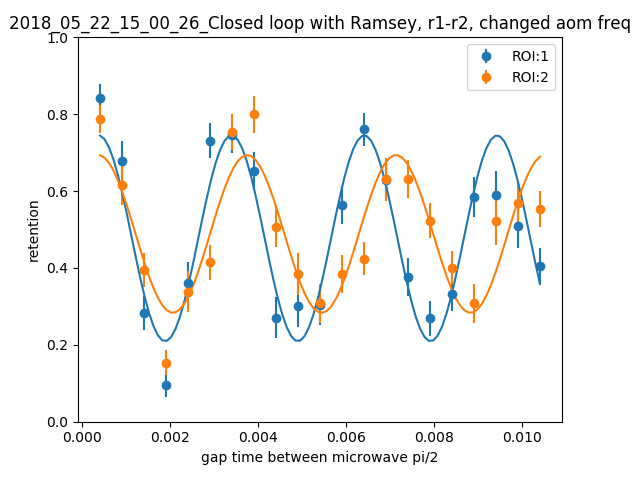

[0.017, 0.35286934043409807, 350, 1.5707963267948966, 0.48998780242304479]
tau 1  is  -394416.39941  with 1 std of   1.82840279474e+12
amplitude 1  is  0.267775794247  with 1 std of   0.0413938375004
frequency 1  is  331.289653944  with 1 std of   5.12152191032
phase 1  is  0.802518517313  with 1 std of   0.204745645828
offset 1  is  0.477197436207  with 1 std of   0.0185304688497
[0.017, 0.30447330447330445, 350, 1.5707963267948966, 0.49552669552669559]
tau 2  is  -139638.131266  with 1 std of   596265089104.0
amplitude 2  is  0.20527251297  with 1 std of   0.0586985721525
frequency 2  is  295.594071469  with 1 std of   7.76549177684
phase 2  is  0.898017252205  with 1 std of   0.292546288173
offset 2  is  0.488554449567  with 1 std of   0.0197174109512
2018_05_22_16_02_17_Closed loop with Ramsey, r1-r2, changed aom freq
1


<IPython.core.display.Javascript object>


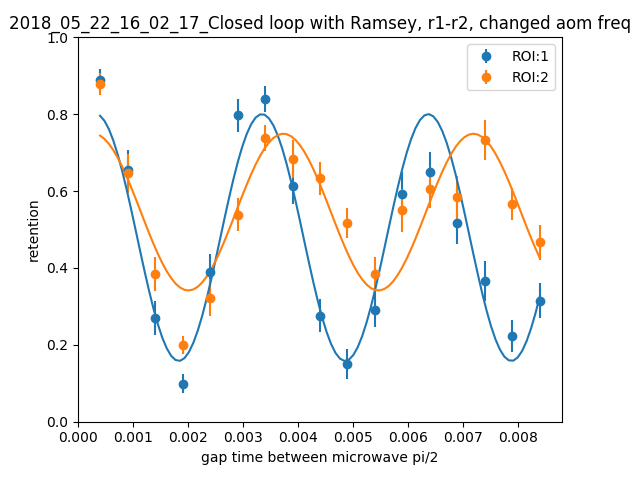

[0.017, 0.42209385360943763, 350, 1.5707963267948966, 0.46679503527945121]
tau 1  is  -256609.021627  with 1 std of   1.37492541273e+12
amplitude 1  is  0.321138362015  with 1 std of   0.0560458559121
frequency 1  is  330.661042626  with 1 std of   6.99789900731
phase 1  is  0.905569310138  with 1 std of   0.224644120641
offset 1  is  0.479227888324  with 1 std of   0.0205836565539
[0.017, 0.32391839918358722, 350, 1.5707963267948966, 0.55486947960429156]
tau 2  is  -302291.256069  with 1 std of   1.704972954e+12
amplitude 2  is  0.203907491456  with 1 std of   0.0517501041464
frequency 2  is  289.37730004  with 1 std of   11.5893322636
phase 2  is  1.06435899419  with 1 std of   0.359186234635
offset 2  is  0.545315464224  with 1 std of   0.0329299778214
2018_05_23_01_17_11_Closed loop with atoms
2


<IPython.core.display.Javascript object>


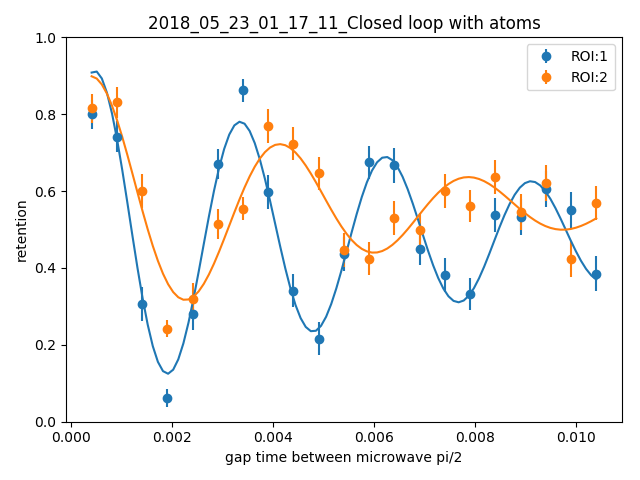

[0.017, 0.36508769455305096, 350, 1.5707963267948966, 0.49661443310652348]
tau 1  is  0.00786067772951  with 1 std of   0.00148722832451
amplitude 1  is  0.456704284612  with 1 std of   0.0446675879467
frequency 1  is  347.057494954  with 1 std of   4.33683451189
phase 1  is  0.503081594064  with 1 std of   0.118536135886
offset 1  is  0.482590056597  with 1 std of   0.0123567419678
[0.017, 0.26543456543456556, 350, 1.5707963267948966, 0.56533466533466525]
tau 2  is  0.00516953438509  with 1 std of   0.00140163410355
amplitude 2  is  0.372310293385  with 1 std of   0.0621349812595
frequency 2  is  267.575072573  with 1 std of   9.76718116995
phase 2  is  0.800341503484  with 1 std of   0.221126312467
offset 2  is  0.55571900062  with 1 std of   0.0155861246726
2018_05_23_01_36_47_Closed loop with atoms
3


<IPython.core.display.Javascript object>


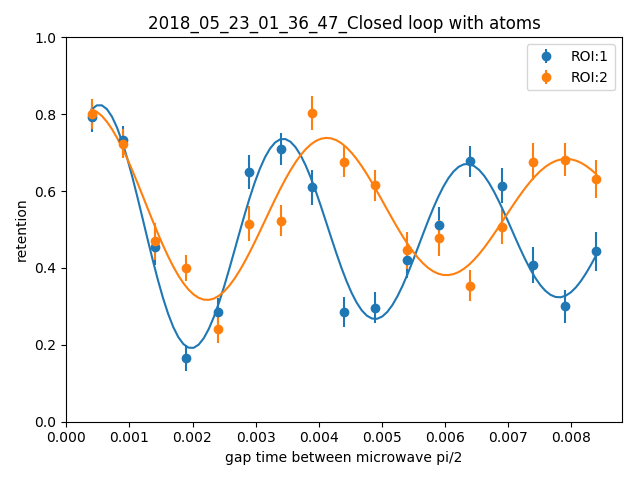

[0.017, 0.30063191687195512, 350, 1.5707963267948966, 0.49157587533583713]
tau 1  is  0.0097046633159  with 1 std of   0.0030159254165
amplitude 1  is  0.359475095957  with 1 std of   0.0432437344625
frequency 1  is  343.208770132  with 1 std of   5.48921007528
phase 1  is  0.395462247549  with 1 std of   0.142725207838
offset 1  is  0.48410829446  with 1 std of   0.0131659518733
[0.017, 0.24163617600150089, 350, 1.5707963267948966, 0.56139412702880209]
tau 2  is  0.011431015167  with 1 std of   0.00572114180825
amplitude 2  is  0.277872512403  with 1 std of   0.049658574237
frequency 2  is  263.442450844  with 1 std of   8.61572164903
phase 2  is  0.96877435123  with 1 std of   0.224561618966
offset 2  is  0.545043963639  with 1 std of   0.0158839558089
2018_05_23_09_57_07_Closed loop with atoms
4


<IPython.core.display.Javascript object>


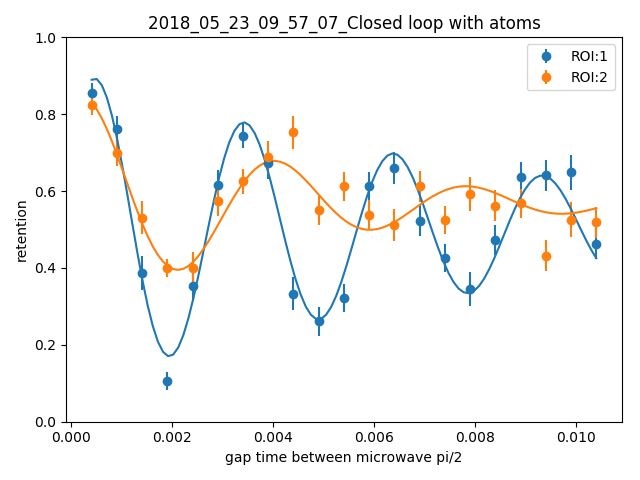

[0.017, 0.33847573926464281, 350, 1.5707963267948966, 0.51622511543621186]
tau 1  is  0.00860208691818  with 1 std of   0.00165831741334
amplitude 1  is  0.41458751925  with 1 std of   0.0386688124905
frequency 1  is  338.319302165  with 1 std of   3.86137242015
phase 1  is  0.536306870057  with 1 std of   0.110973770301
offset 1  is  0.500608569287  with 1 std of   0.0108731987921
[0.017, 0.25142563198118739, 350, 1.5707963267948966, 0.57357436801881256]
tau 2  is  0.00415249095368  with 1 std of   0.00120620356393
amplitude 2  is  0.291759449905  with 1 std of   0.0572437539364
frequency 2  is  262.911260363  with 1 std of   12.8888087284
phase 2  is  1.08392951237  with 1 std of   0.251295134869
offset 2  is  0.568774884718  with 1 std of   0.0125703803861
2018_05_23_10_33_33_Closed loop with atoms
5


<IPython.core.display.Javascript object>


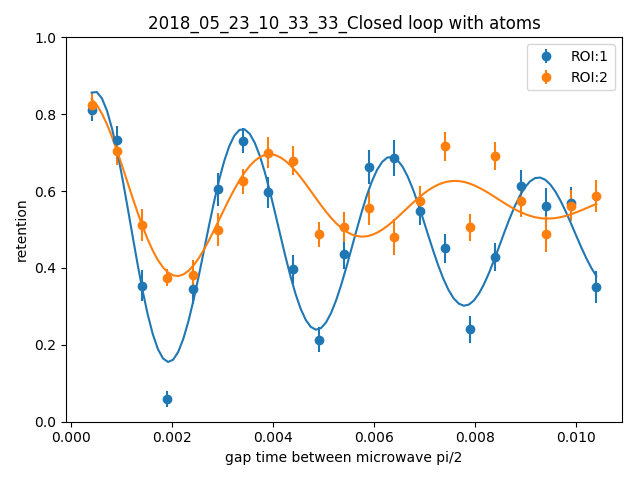

[0.017, 0.31692219017429529, 350, 1.5707963267948966, 0.49504362179151667]
tau 1  is  0.00982916145044  with 1 std of   0.00224418223933
amplitude 1  is  0.396699067424  with 1 std of   0.0405292153947
frequency 1  is  340.992200297  with 1 std of   4.03268461372
phase 1  is  0.539792927213  with 1 std of   0.120563346269
offset 1  is  0.481072751004  with 1 std of   0.0117458983102
[0.017, 0.25191798941798937, 350, 1.5707963267948966, 0.57308201058201058]
tau 2  is  0.0046962234314  with 1 std of   0.00137321808239
amplitude 2  is  0.297530109562  with 1 std of   0.0558650554714
frequency 2  is  272.477866902  with 1 std of   11.1854696097
phase 2  is  1.00388932304  with 1 std of   0.238299414134
offset 2  is  0.567992757249  with 1 std of   0.0130811577024
2018_05_23_11_10_20_Closed loop with atoms
6


<IPython.core.display.Javascript object>


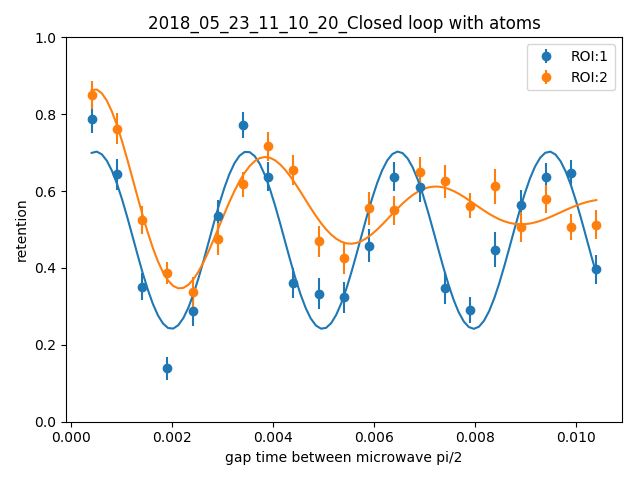

[0.017, 0.30220759861138352, 350, 1.5707963267948966, 0.48602769550626351]
tau 1  is  -296261.889789  with 1 std of   1.1837763171e+12
amplitude 1  is  0.230606412613  with 1 std of   0.0349271325623
frequency 1  is  333.875411675  with 1 std of   4.8454397752
phase 1  is  0.558571286409  with 1 std of   0.197255622777
offset 1  is  0.472245923391  with 1 std of   0.0158156742933
[0.017, 0.2842886537330982, 350, 1.5707963267948966, 0.56571134626690178]
tau 2  is  0.00406251247482  with 1 std of   0.000797268508311
amplitude 2  is  0.353070406208  with 1 std of   0.0451758114423
frequency 2  is  295.880194054  with 1 std of   9.16214367783
phase 2  is  0.581018220324  with 1 std of   0.178378721388
offset 2  is  0.552680284654  with 1 std of   0.0104064674648
2018_05_23_13_54_23_Closed loop with atoms
7


<IPython.core.display.Javascript object>


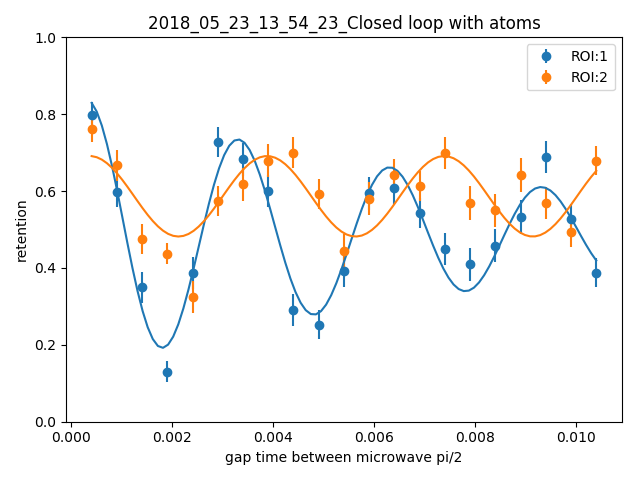

[0.017, 0.30209667673492857, 350, 1.5707963267948966, 0.49577566369060333]
tau 1  is  0.00865597615995  with 1 std of   0.0020349413566
amplitude 1  is  0.363323392154  with 1 std of   0.0416524046626
frequency 1  is  333.074093129  with 1 std of   4.56278935649
phase 1  is  0.889941208051  with 1 std of   0.130719900347
offset 1  is  0.486772134381  with 1 std of   0.0114498409259
[0.017, 0.17629335684891234, 350, 1.5707963267948966, 0.58620664315108761]
tau 2  is  -119438.306326  with 1 std of   462674487315.0
amplitude 2  is  -0.104705404826  with 1 std of   0.0400985234275
frequency 2  is  284.861026433  with 1 std of   13.1946263631
phase 2  is  4.05980606777  with 1 std of   0.525749419381
offset 2  is  0.586503775859  with 1 std of   0.0186614284669
2018_05_23_14_17_56_Closed loop with atoms
8


<IPython.core.display.Javascript object>


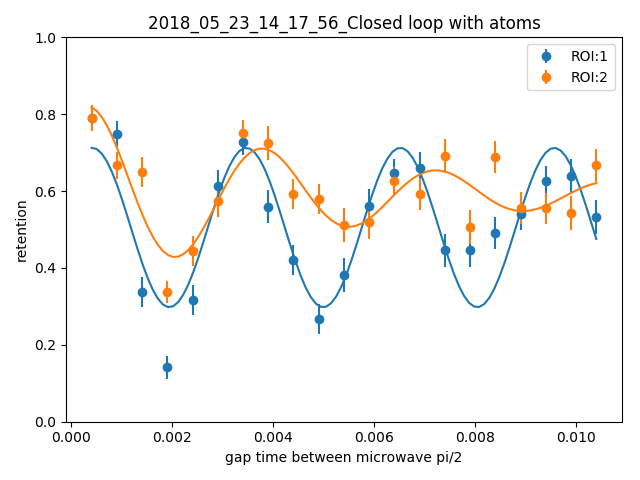

[0.017, 0.27213247150526798, 350, 1.5707963267948966, 0.51834371897092246]
tau 1  is  -178431.958083  with 1 std of   558896923796.0
amplitude 1  is  0.207371521005  with 1 std of   0.0380650383975
frequency 1  is  327.765087517  with 1 std of   6.88073447174
phase 1  is  0.717081172515  with 1 std of   0.277081726621
offset 1  is  0.505217433301  with 1 std of   0.0190429649206
[0.017, 0.19173280423280425, 350, 1.5707963267948966, 0.59839065255731916]
tau 2  is  0.00527806356836  with 1 std of   0.00210489288416
amplitude 2  is  0.24322556509  with 1 std of   0.0597548061008
frequency 2  is  290.205961258  with 1 std of   13.9273336622
phase 2  is  0.869907533765  with 1 std of   0.316885455641
offset 2  is  0.592425982718  with 1 std of   0.0149405286286
2018_05_23_14_40_03_Closed loop with atoms
9


<IPython.core.display.Javascript object>


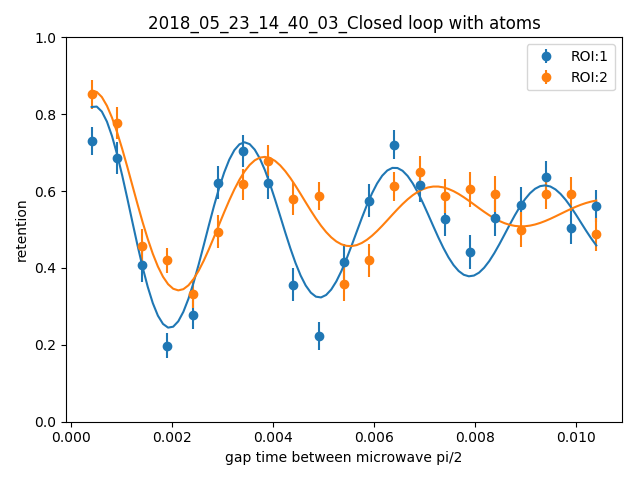

[0.017, 0.20998440669464924, 350, 1.5707963267948966, 0.52001559330535074]
tau 1  is  0.00834290989737  with 1 std of   0.00265287095123
amplitude 1  is  0.332355124461  with 1 std of   0.0519272861432
frequency 1  is  336.291526381  with 1 std of   6.53490456994
phase 1  is  0.545773793895  with 1 std of   0.186233892849
offset 1  is  0.507079657628  with 1 std of   0.0144920428715
[0.017, 0.29016754850088178, 350, 1.5707963267948966, 0.56168430335097008]
tau 2  is  0.0042220139054  with 1 std of   0.00109653716968
amplitude 2  is  0.346996489741  with 1 std of   0.0582970508825
frequency 2  is  294.376845493  with 1 std of   11.674486013
phase 2  is  0.656642770911  with 1 std of   0.233123535275
offset 2  is  0.549813362576  with 1 std of   0.0136789507776
2018_05_23_15_06_01_Closed loop with atoms
10


<IPython.core.display.Javascript object>


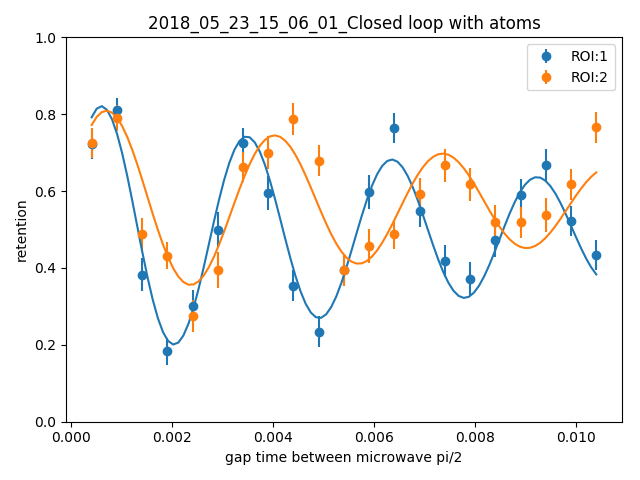

[0.017, 0.30573741159711898, 350, 1.5707963267948966, 0.50426258840288107]
tau 1  is  0.010588725148  with 1 std of   0.0026319863266
amplitude 1  is  0.350596624607  with 1 std of   0.0374808142113
frequency 1  is  347.453071283  with 1 std of   4.04114345275
phase 1  is  0.234403050754  with 1 std of   0.122363661631
offset 1  is  0.489859756098  with 1 std of   0.0108579528616
[0.017, 0.21360229276895948, 350, 1.5707963267948966, 0.57652116402116393]
tau 2  is  0.0108974961455  with 1 std of   0.00570393336012
amplitude 2  is  0.260339657383  with 1 std of   0.0574063749943
frequency 2  is  300.212908661  with 1 std of   8.26415917965
phase 2  is  0.21246665815  with 1 std of   0.2518402944
offset 2  is  0.565257367526  with 1 std of   0.016766785059
2018_05_23_20_45_08_Closed loop with atoms
11


<IPython.core.display.Javascript object>


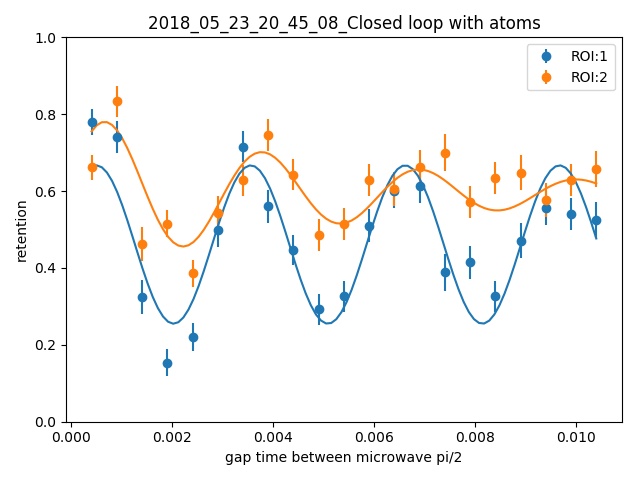

[0.017, 0.30330451891608667, 350, 1.5707963267948966, 0.4765119948453812]
tau 1  is  -238331.712202  with 1 std of   1.00303198535e+12
amplitude 1  is  0.206000887918  with 1 std of   0.0330180089558
frequency 1  is  326.857392618  with 1 std of   6.8114708302
phase 1  is  0.555921904885  with 1 std of   0.273173922425
offset 1  is  0.460978192022  with 1 std of   0.0187397622689
[0.017, 0.227118309814487, 350, 1.5707963267948966, 0.60621502351884637]
tau 2  is  0.0056001349264  with 1 std of   0.00284119031793
amplitude 2  is  0.208404065888  with 1 std of   0.0654489917746
frequency 2  is  321.226004504  with 1 std of   16.160860182
phase 2  is  0.15992648149  with 1 std of   0.373786963256
offset 2  is  0.595586763447  with 1 std of   0.0158575897202
2018_05_23_21_07_39_Closed loop with atoms
12


<IPython.core.display.Javascript object>


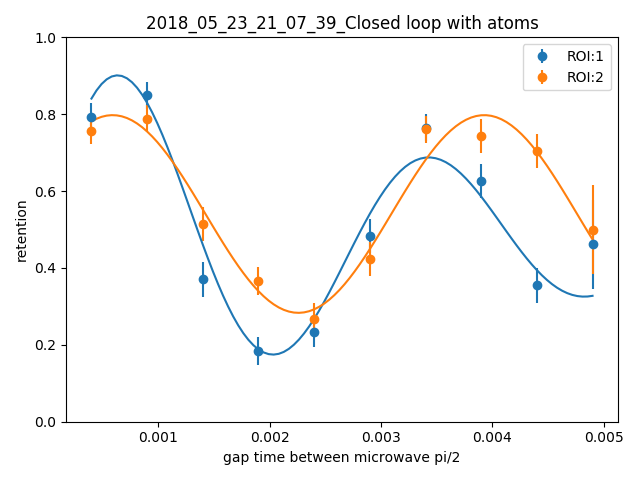

[0.017, 0.33709768217451641, 350, 1.5707963267948966, 0.51221738631863423]
tau 1  is  0.00401490199619  with 1 std of   0.00184326027873
amplitude 1  is  0.501695651819  with 1 std of   0.123438775422
frequency 1  is  357.837203473  with 1 std of   21.0980325516
phase 1  is  0.0354131971251  with 1 std of   0.291658884278
offset 1  is  0.475311983492  with 1 std of   0.0320843157709
[0.017, 0.20631790744466805, 350, 1.5707963267948966, 0.58241448692152908]
tau 2  is  -33376.8090837  with 1 std of   74521607094.4
amplitude 2  is  0.257178803221  with 1 std of   0.0495491600017
frequency 2  is  299.624961777  with 1 std of   11.2276230239
phase 2  is  0.46068533842  with 1 std of   0.235489080641
offset 2  is  0.540426130903  with 1 std of   0.0183224665435
2018_05_24_01_13_31_Closed loop with atoms, extended BA
13


<IPython.core.display.Javascript object>


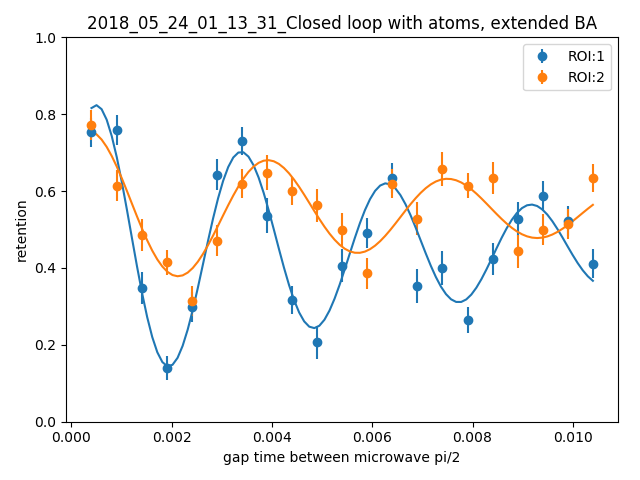

[0.017, 0.29481695491492016, 350, 1.5707963267948966, 0.46421918966339309]
tau 1  is  0.00735178119423  with 1 std of   0.00170947118356
amplitude 1  is  0.399870732368  with 1 std of   0.0496256363385
frequency 1  is  345.715822766  with 1 std of   5.63277932514
phase 1  is  0.438358918674  with 1 std of   0.150418144759
offset 1  is  0.450336023564  with 1 std of   0.0134466789704
[0.017, 0.22225735364568366, 350, 1.5707963267948966, 0.5491712177828878]
tau 2  is  0.00799170423406  with 1 std of   0.00337595829925
amplitude 2  is  0.219606196137  with 1 std of   0.0466433836126
frequency 2  is  279.137366389  with 1 std of   9.02527260982
phase 2  is  0.913206689961  with 1 std of   0.25326715303
offset 2  is  0.546335727126  with 1 std of   0.0129878030282
2018_05_24_01_38_13_Closed loop with atoms, FORT lowered
14


<IPython.core.display.Javascript object>


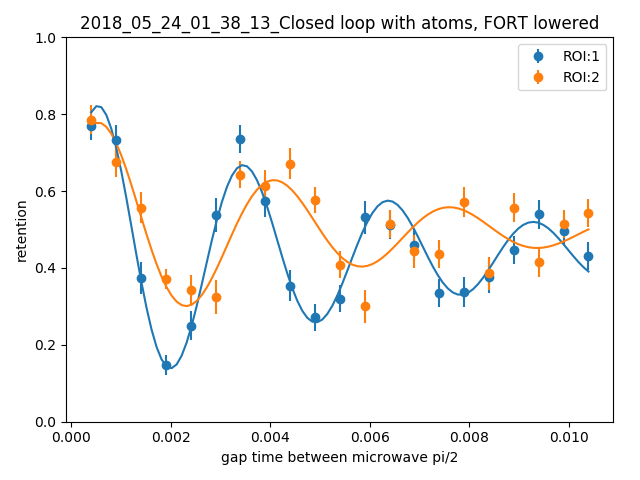

[0.017, 0.31603417476097917, 350, 1.5707963267948966, 0.45408076776775641]
tau 1  is  0.0056950386858  with 1 std of   0.000734383290383
amplitude 1  is  0.424550323762  with 1 std of   0.0326978494198
frequency 1  is  342.824785863  with 1 std of   3.9735150164
phase 1  is  0.332207047821  with 1 std of   0.0943543550212
offset 1  is  0.43702882139  with 1 std of   0.0081374984289
[0.017, 0.27851873143623651, 350, 1.5707963267948966, 0.50719555427804919]
tau 2  is  0.00469379429674  with 1 std of   0.00169617201925
amplitude 2  is  0.320154290029  with 1 std of   0.0725784766362
frequency 2  is  283.41703599  with 1 std of   13.7838362257
phase 2  is  0.482319556096  with 1 std of   0.297365084842
offset 2  is  0.495137253813  with 1 std of   0.0174001403541
2018_05_24_11_39_12_Closed loop with atoms
15


<IPython.core.display.Javascript object>


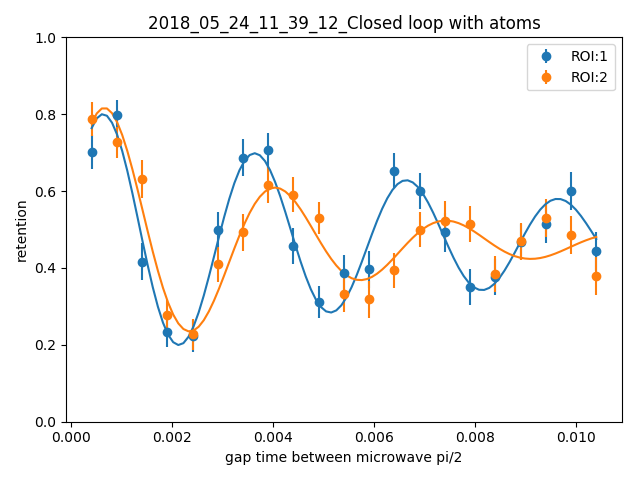

[0.017, 0.30605599761563279, 350, 1.5707963267948966, 0.49104545165972951]
tau 1  is  0.00809410685101  with 1 std of   0.00162779730375
amplitude 1  is  0.355173214598  with 1 std of   0.0361234115383
frequency 1  is  332.901196  with 1 std of   4.17133790742
phase 1  is  0.203847385288  with 1 std of   0.116851033797
offset 1  is  0.472099351594  with 1 std of   0.00978164198759
[0.017, 0.30597180597180584, 350, 1.5707963267948966, 0.481906981906982]
tau 2  is  0.0038337545201  with 1 std of   0.00085522949583
amplitude 2  is  -0.423736585572  with 1 std of   0.0643811914388
frequency 2  is  295.810148461  with 1 std of   10.1141260688
phase 2  is  3.35992021182  with 1 std of   0.187617527426
offset 2  is  0.462624858911  with 1 std of   0.0132944487001
2018_05_24_11_56_45_Closed loop with atoms
16


<IPython.core.display.Javascript object>


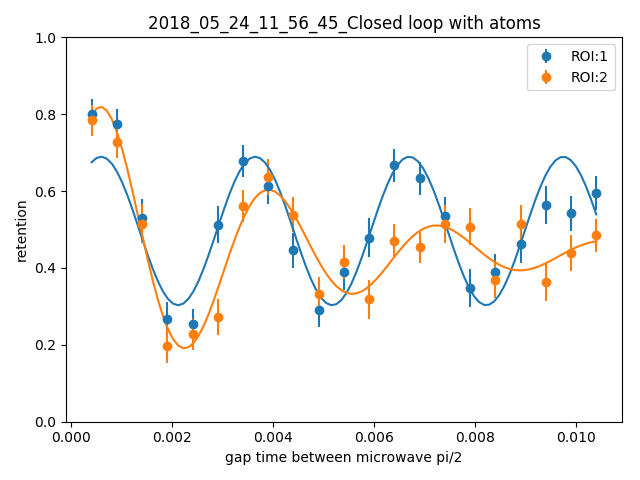

[0.017, 0.2874492064882902, 350, 1.5707963267948966, 0.51255079351170985]
tau 1  is  -737115.646798  with 1 std of   3.12939137397e+12
amplitude 1  is  0.193214810742  with 1 std of   0.0272563036116
frequency 1  is  327.587629335  with 1 std of   6.61216292711
phase 1  is  0.359601708495  with 1 std of   0.263828966256
offset 1  is  0.496255845312  with 1 std of   0.0173439806809
[0.017, 0.32529692529692528, 350, 1.5707963267948966, 0.45931845931845933]
tau 2  is  0.00395494030173  with 1 std of   0.000783736794137
amplitude 2  is  0.442799808553  with 1 std of   0.0585743754719
frequency 2  is  300.759823626  with 1 std of   9.18887669251
phase 2  is  0.344785856091  with 1 std of   0.174460357647
offset 2  is  0.440099292135  with 1 std of   0.0127985003362
2018_05_24_12_12_20_Closed loop with atoms
17


<IPython.core.display.Javascript object>


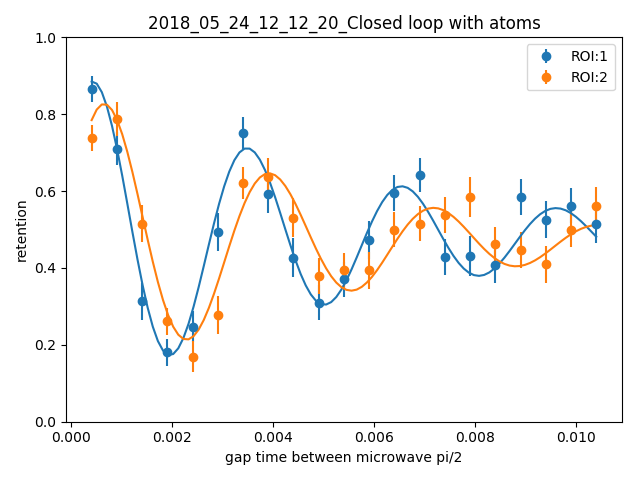

[0.017, 0.36861077133648845, 350, 1.5707963267948966, 0.49625409352837646]
tau 1  is  0.00548223606812  with 1 std of   0.000837951721345
amplitude 1  is  0.439321727136  with 1 std of   0.0403423479063
frequency 1  is  326.671307204  with 1 std of   4.97170957339
phase 1  is  0.622790040576  with 1 std of   0.116535475988
offset 1  is  0.479841146496  with 1 std of   0.0100867968032
[0.017, 0.3012432012432012, 350, 1.5707963267948966, 0.48663558663558665]
tau 2  is  0.00468090082185  with 1 std of   0.000885648619127
amplitude 2  is  0.415544439501  with 1 std of   0.051367155976
frequency 2  is  306.392482122  with 1 std of   7.24713008446
phase 2  is  0.212433431408  with 1 std of   0.151701598916
offset 2  is  0.467273200919  with 1 std of   0.0116925990167
2018_05_24_12_27_22_Closed loop with atoms
18


<IPython.core.display.Javascript object>


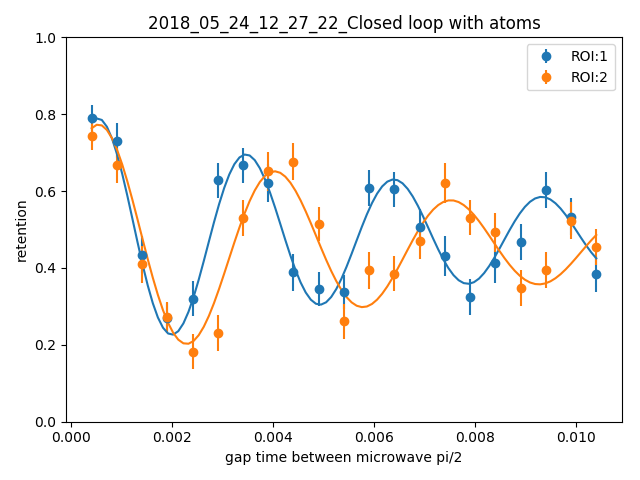

[0.017, 0.2938641338103069, 350, 1.5707963267948966, 0.49560955040021942]
tau 1  is  0.00803777630516  with 1 std of   0.00167925281108
amplitude 1  is  0.328411653854  with 1 std of   0.0346178918838
frequency 1  is  341.087953832  with 1 std of   4.48062360917
phase 1  is  0.389449002867  with 1 std of   0.125200779531
offset 1  is  0.482157557055  with 1 std of   0.00953271998894
[0.017, 0.27808857808857812, 350, 1.5707963267948966, 0.46433566433566431]
tau 2  is  0.00728278153694  with 1 std of   0.00203326271687
amplitude 2  is  0.34484653825  with 1 std of   0.0504300469095
frequency 2  is  286.456154531  with 1 std of   6.63884243234
phase 2  is  0.530121655593  with 1 std of   0.180305349405
offset 2  is  0.453693263292  with 1 std of   0.0139001372733
2018_05_24_12_41_35_Closed loop with atoms
19


<IPython.core.display.Javascript object>


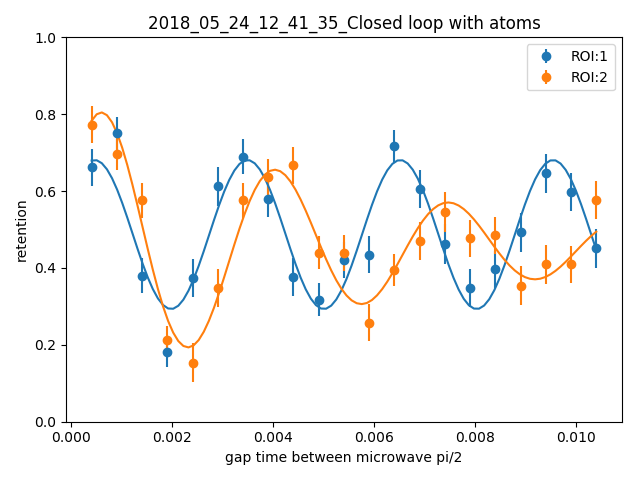

[0.017, 0.2504250565207003, 350, 1.5707963267948966, 0.4995749434792997]
tau 1  is  -215683.569893  with 1 std of   824380276424.0
amplitude 1  is  0.193855332168  with 1 std of   0.026796306121
frequency 1  is  330.274943663  with 1 std of   5.5599987601
phase 1  is  0.616520573966  with 1 std of   0.225537307186
offset 1  is  0.487032140659  with 1 std of   0.0149547697227
[0.017, 0.30159840159840162, 350, 1.5707963267948966, 0.47112887112887109]
tau 2  is  0.00615119024327  with 1 std of   0.00134363301929
amplitude 2  is  0.384764066161  with 1 std of   0.0481095251487
frequency 2  is  290.9294041  with 1 std of   6.18333317281
phase 2  is  0.401562837172  with 1 std of   0.154523991476
offset 2  is  0.456567754886  with 1 std of   0.0124740073305
2018_05_24_12_56_48_Closed loop with atoms
20


<IPython.core.display.Javascript object>


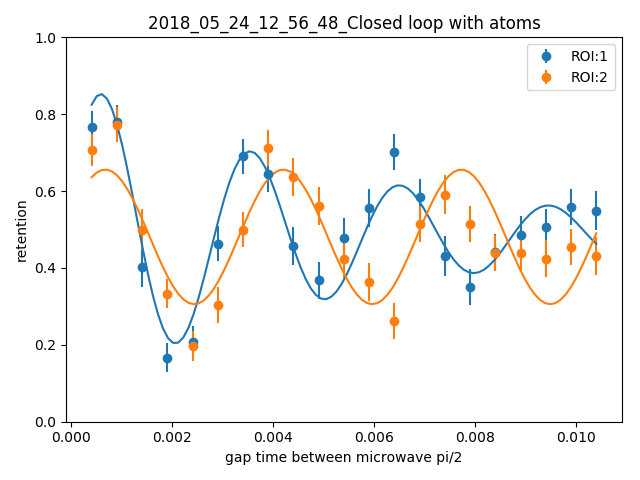

[0.017, 0.27530081144001195, 350, 1.5707963267948966, 0.50436020550914062]
tau 1  is  0.005666099158  with 1 std of   0.00121468686365
amplitude 1  is  0.407512242337  with 1 std of   0.0523671438936
frequency 1  is  338.277291708  with 1 std of   6.49673677362
phase 1  is  0.251650774481  with 1 std of   0.154198582382
offset 1  is  0.486034696053  with 1 std of   0.0128492133923
[0.017, 0.29264069264069259, 350, 1.5707963267948966, 0.48008658008658012]
tau 2  is  -155969.589711  with 1 std of   824258324679.0
amplitude 2  is  -0.175120592908  with 1 std of   0.0584775170112
frequency 2  is  283.497080023  with 1 std of   8.65912851355
phase 2  is  3.51977244159  with 1 std of   0.342691644338
offset 2  is  0.480852641456  with 1 std of   0.0193297037617
2018_05_24_13_09_08_Closed loop with atoms
21


<IPython.core.display.Javascript object>


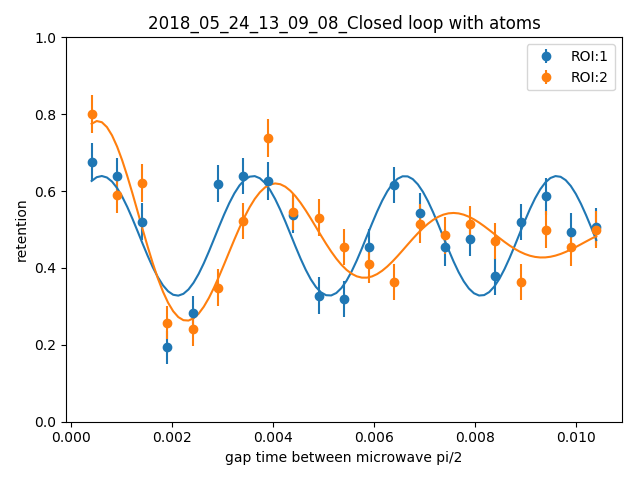

[0.017, 0.18121605409626795, 350, 1.5707963267948966, 0.49570702282680901]
tau 1  is  -218554.220025  with 1 std of   1.0318045809e+12
amplitude 1  is  0.15565544311  with 1 std of   0.04166046751
frequency 1  is  332.615450249  with 1 std of   8.16940146135
phase 1  is  0.325650248298  with 1 std of   0.330928341338
offset 1  is  0.483582480012  with 1 std of   0.0172691685937
[0.017, 0.31294261294261305, 350, 1.5707963267948966, 0.48705738705738699]
tau 2  is  0.00469753616311  with 1 std of   0.00141208205828
amplitude 2  is  0.346566279187  with 1 std of   0.0651845693067
frequency 2  is  283.812534931  with 1 std of   11.5230738673
phase 2  is  0.523317585006  with 1 std of   0.248871503764
offset 2  is  0.474426394167  with 1 std of   0.0157196322029
2018_05_24_13_22_39_Closed loop with atoms
22


<IPython.core.display.Javascript object>


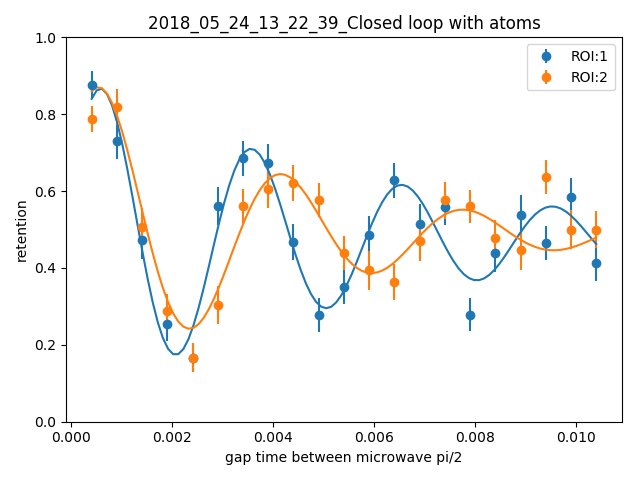

[0.017, 0.38079292721273533, 350, 1.5707963267948966, 0.49613014971034158]
tau 1  is  0.00581915813333  with 1 std of   0.00123607757458
amplitude 1  is  0.432562592492  with 1 std of   0.0544005697362
frequency 1  is  335.263326112  with 1 std of   6.28229167462
phase 1  is  0.278393752139  with 1 std of   0.151551272182
offset 1  is  0.47625916216  with 1 std of   0.0135241712077
[0.017, 0.31354201354201361, 350, 1.5707963267948966, 0.50463980463980462]
tau 2  is  0.00404924540932  with 1 std of   0.000902340739627
amplitude 2  is  0.441495887609  with 1 std of   0.0640936916281
frequency 2  is  277.049797183  with 1 std of   10.1281673197
phase 2  is  0.503397891344  with 1 std of   0.198335342535
offset 2  is  0.487242031847  with 1 std of   0.0145813053562


In [37]:
save_figures=False
data11 = []
for n in range(0,len(assorted['exp_ids'])):    
    print assorted['exp_ids'][n]
    assorted_roi3freqs=[]
    assorted_roi2freqs=[]
    assorted_roi3perr=[]
    assorted_roi2perr=[]
    i = n
    print i
    exp_id=assorted['exp_ids'][i]
    q=assorted['qdp_class'][i]
    q.experiments[0]['variable_list']
    xlab = q.experiments[0]['variable_desc'][q.experiments[0]['variable_list'][0]]['description']
    q.get_thresholds()
    retention = q.apply_thresholds()


    colors=[ '#ff7f0e','#1f77b4','#ff7f0e', '#2ca02c', '#d62728','#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    fig, ax = plt.subplots()
    fit_guesses=[0.01, 0.40, 350 ,1.3, 0.5]
    fit_guesses2=[0.01, 0.25, 200 ,1.3, 0.45]
    #roi_dependency=[0,0,0,0,0]
    fitted_parameters=[]
    freqarray = []
    for roi in [1,2]:
        error=0
        data = []
        reten = []
        err = []

        for e in range(len(np.squeeze(retention['ivar']))):
            data.append(np.squeeze(retention['ivar'])[e][roi])
            reten.append(np.squeeze(retention['retention'])[e][roi])
            err.append(np.squeeze(retention['error'])[e][roi])
        offsetguess = np.mean(reten)
        Ampguess = np.max(reten)-offsetguess
        fit_guesses = [0.017,Ampguess , 350 ,np.pi/2, offsetguess]   
        print fit_guesses
        ax.errorbar(data,reten,yerr=err,label="ROI:{}".format(roi),fmt='o',color=colors[roi])
        #guesses=np.add(fit_guesses,np.ones(len(fit_guesses))*(roi-2)*roi_dependency)
        #try:
       # decaying_sin(t,tau,amp,freq,phase,offset)
        try:
            fit,pcov = curve_fit(decaying_sin,data,reten,fit_guesses) #gaussian(x,amp,x0,sigma,offset):
            perr = np.sqrt(np.diag(pcov))
            print 'tau',roi," is ", fit[0]," with 1 std of  ", perr[0]
            print 'amplitude',roi," is ", fit[1]," with 1 std of  ", perr[1]
            print 'frequency',roi," is ", fit[2]," with 1 std of  ", perr[2]
            print 'phase', roi," is ", fit[3]," with 1 std of  ", perr[3]
            print 'offset',roi," is ", fit[4]," with 1 std of  ", perr[4]
            freqarray.append(fit[2])
            freqarray.append(perr[2])

        except:
            fit,pcov = curve_fit(decaying_sin,data,reten,fit_guesses2) #gaussian(x,amp,x0,sigma,offset):
            perr = np.sqrt(np.diag(pcov))
            print 'tau',roi," is ", fit[0]," with 1 std of  ", perr[0]
            print 'amplitude',roi," is ", fit[1]," with 1 std of  ", perr[1]
            print 'frequency',roi," is ", fit[2]," with 1 std of  ", perr[2]
            print 'phase', roi," is ", fit[3]," with 1 std of  ", perr[3]
            print 'offsett',roi," is ", fit[4]," with 1 std of  ", perr[4]
            freqarray.append(fit[2])
            freqarray.append(perr[2])

           #fit2,pcov2 = curve_fit(gaussian,data,reten,fit_guesses2) #gaussian(x,amp,x0,sigma,offset):
       # except RuntimeError:
       #     error=1
    #     if error is not 1:
    #         print "amplitude: {} , x0: {}, sigma:{} ".format(fit[0],fit[1],fit[2])
    #         print "amplitude: {} , x0: {}, sigma:{} ".format(fit2[0],fit2[1],fit2[2])

        xarray=np.linspace(np.min(data),np.max(data),100)
        yfit=decaying_sin(xarray, fit[0], fit[1], fit[2], fit[3],fit[4])
        plt.plot(xarray,yfit,color=colors[roi])
           # yfit2=gaussian(xarray, fit2[0], fit2[1], fit2[2], fit2[3])
            #plt.plot(xarray,yfit,label="mj=5/2", color=colors[0])
            #plt.plot(xarray,yfit2,label="mj=3/2", color=colors[1])

    #         if roi==3:
    #             assorted_roi3freqs.append(fit[2])
    #             assorted_roi3perr.append(np.sqrt(pcov[2][2]))
    #         elif roi==2:
    #             assorted_roi2freqs.append(fit[2])
    #             assorted_roi2perr.append(np.sqrt(pcov[2][2]))

    ax.set_title(exp_id)
    ax.set_ylim(0, 1)
    ax.set_xlabel(xlab)
    ax.set_ylabel('retention')
    ax.legend()
    plt.tight_layout()
    plt.show()
    if save_figures:
        plt.savefig('{}.pdf'.format(exp_id))
    
    
    
    starting_time = dt.datetime.fromtimestamp(int(assorted['timestamps'][i][0])).strftime('%Y-%m-%d %H:%M:%S')
    end_time = dt.datetime.fromtimestamp(int(assorted['timestamps'][i][len(assorted['timestamps'][i])-1])).strftime('%Y-%m-%d %H:%M:%S')
    middle_time = dt.datetime.fromtimestamp(int((assorted['timestamps'][i][0]+assorted['timestamps'][i][len(assorted['timestamps'][i])-1])/2 )).strftime('%H:%M')
    time_length = (assorted['timestamps'][i][len(assorted['timestamps'][i])-1])-assorted['timestamps'][i][0]
    time_from_data_start = ((assorted['timestamps'][i][0]+assorted['timestamps'][i][len(assorted['timestamps'][i])-1])/2 ) - assorted['timestamps'][0][0] 
    data11.append([ starting_time,end_time,freqarray[0],freqarray[1],freqarray[2],freqarray[3],middle_time,time_length,time_from_data_start])



<IPython.core.display.Javascript object>


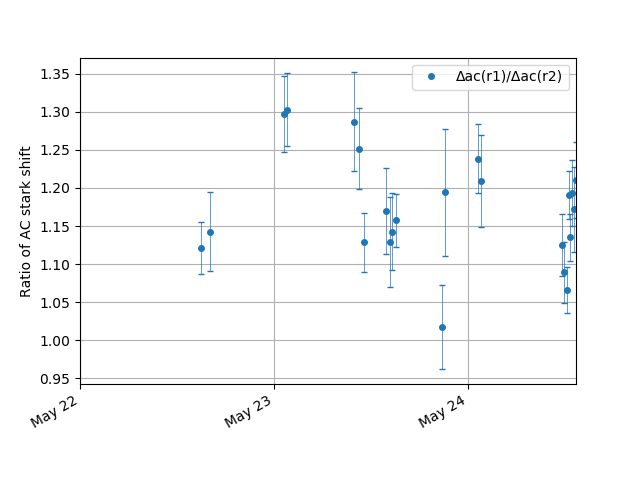

<IPython.core.display.Javascript object>


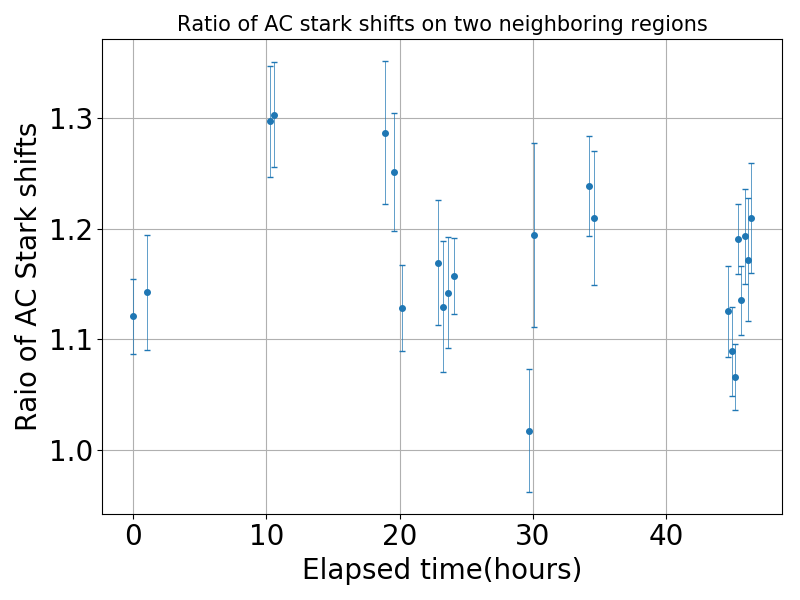

In [38]:
savefig=False
ratio_data=[]
ratio_error=[]
avetimestamp=[]
timelength=[]
startingtime=[]
startingtime_in_UNIX=[]

for i in range(0,len(assorted['exp_ids'])):
    startingtime.append(dt.datetime.fromtimestamp(assorted['timestamps'][i][0]))
    startingtime_in_UNIX.append(assorted['timestamps'][i][0])
    ratio_data.append(data11[i][2]/data11[i][4])
    error_total=np.sqrt(((1/data11[i][4])*data11[i][3])**2+(((data11[i][2]/(data11[i][4])**2)*data11[i][5])**2))
    ratio_error.append(error_total)
    avetimestamp.append(data11[i][6])

#samplerate='2S'
#df=pd.DataFrame({  "Δac(r1)/Δac(r2)": ratio_data,'timestamps': avetimestamp,'error': ratio_error,'off_data': off_data},index=startingtime)
df=pd.DataFrame({  "Δac(r1)/Δac(r2)": ratio_data,'timestamps': avetimestamp,'error': ratio_error},index=startingtime)

ax=df.plot(y=[ "Δac(r1)/Δac(r2)"],yerr='error',capsize=2,alpha=1,lw=0.5,marker='o',markersize=4,linestyle='None',color=['#1f77b4', '#d62728'])
days=md.DayLocator()
hours=md.HourLocator()
ax.set_xlim(dt.datetime(2018,5,22))
ax.xaxis.set_major_locator(days)
ax.xaxis.set_major_formatter(md.DateFormatter('%b %d'))
ax.set_ylabel('Ratio of AC stark shift')
ax.grid()
#plt.savefig('Alignment_20180415.png')

timediff=(startingtime_in_UNIX-startingtime_in_UNIX[0])/(3600)
fig, ax = plt.subplots()
fig.set_size_inches(8,6)
ax.errorbar(timediff,ratio_data,yerr=ratio_error,capsize=2,alpha=1,lw=0.5,marker='o',markersize=4,linestyle='None')
ax.set_xlabel('Elapsed time(hours)',fontsize=20)
ax.set_ylabel('Raio of AC Stark shifts',fontsize=20)
ax.set_title('Ratio of AC stark shifts on two neighboring regions',fontsize=15)
#ax.set_ylim(-0.3,0.3)
ax.tick_params(labelsize=20)
ax.grid()
plt.tight_layout()
filename='AC Stark shift ratios'
if savefig:
    plt.savefig(filename+'.png')
    plt.savefig(filename+'.pdf')
    plt.savefig(filename+'.eps')

<IPython.core.display.Javascript object>


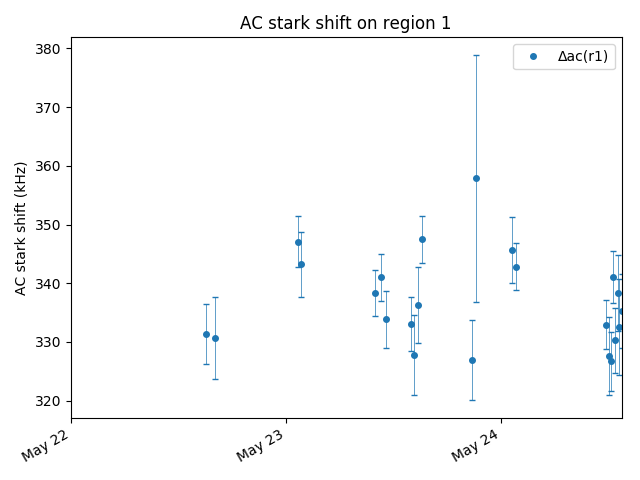

<IPython.core.display.Javascript object>


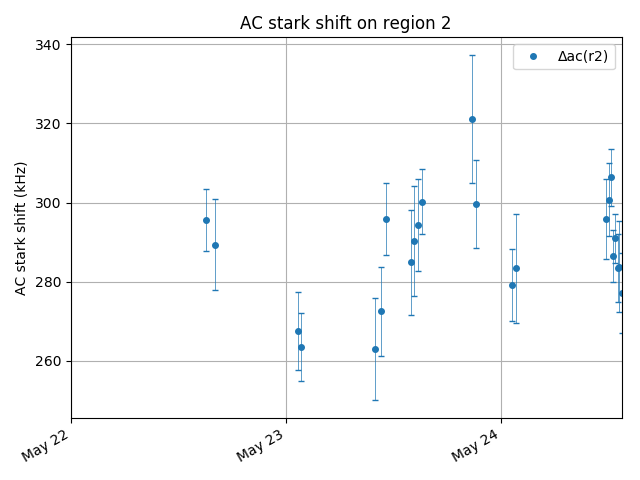

In [39]:

ROI1_ac=[]
ROI1_err=[]
ROI2_ac=[]
ROI2_err=[]
avetimestamp=[]
timelength=[]
startingtime=[]
ROI_err=[]

for i in range(0,len(assorted['exp_ids'])):
    startingtime.append(dt.datetime.fromtimestamp(assorted['timestamps'][i][0]))
    ROI1_ac.append(data11[i][2])
    ROI_err.append([data11[i][3],data11[i][5]])
   # ROI_err.append(data11[i][3])
   # ROI_err.append(data11[i][5])
    ROI1_err.append(data11[i][3])
    ROI2_ac.append(data11[i][4])
    ROI2_err.append(data11[i][5])
    #ratio_error.append(error_total)
    avetimestamp.append(data11[i][6])
 
# Using Pandas

df2=pd.DataFrame({  "Δac(r1)": ROI1_ac,'Δac(r2)':ROI2_ac,'timestamps': avetimestamp,'ROI_err': ROI_err},index=startingtime)

ax=df2.plot(y=[ "Δac(r1)"],yerr=ROI1_err,capsize=2,alpha=1,lw=0.5,marker='o',markersize=4,linestyle='None')
hours=md.HourLocator()
ax.set_xlim(dt.datetime(2018,5,22))
ax.xaxis.set_major_locator(days)
#ax.xaxis.set_minor_locator(hours)
ax.xaxis.set_major_formatter(md.DateFormatter('%b %d'))
ax.set_ylabel('AC stark shift (kHz)')
ax.grid()
ax.set_title('AC stark shift on region 1')
plt.tight_layout()
if savefig:
    plt.savefig('r1_ac_starkshift.pdf')

ax2=df2.plot(y=[ "Δac(r2)"],yerr=ROI2_err,capsize=2,alpha=1,lw=0.5,marker='o',markersize=4,linestyle='None')
hours=md.HourLocator()
ax2.set_xlim(dt.datetime(2018,5,22))
ax2.xaxis.set_major_locator(days)
ax2.xaxis.set_major_formatter(md.DateFormatter('%b %d'))
ax2.set_ylabel('AC stark shift')
ax2.grid()
ax2.set_ylabel('AC stark shift (kHz)')
ax2.set_title('AC stark shift on region 2')
plt.tight_layout()
if savefig:
    plt.savefig('r2_ac_starkshift.pdf')


In [40]:
ax.set_ylabel('AC stark shift (kHz)')
ax.grid()
ax.set_title('AC stark shift on region 1')
plt.tight_layout()
plt.savefig('r1_ac_starkshift')
# peakshift_r1 = 825.0
# peakshift_r2 = 825.0
# wx_r1 = 8.2
# wx_r2= 8.2
peakshift=825
wx=8.1
spacing = 9.25
xx = np.arange(-10.0, 10.0, 0.1)
# fig, ax = plt.subplots()
# plt.plot(xx,gaussian(xx,peakshift,-spacing/2,wx,0))
# plt.plot(xx,gaussian(xx,peakshift,spacing/2,wx,0))
# plt.show()

# fig, ax = plt.subplots()
# xxx = np.arange(-.3, 0.3, 0.005)
# plt.plot(xxx,(gaussian(xxx,peakshift,spacing/2,wx,0)/gaussian(xxx,peakshift,-spacing/2,wx,0)))
# plt.show()


In [41]:
def gaussian2(x,amp,x0,sigma,offset):
    res=(amp*sp.exp((-2.0*(x-x0)**2)/(sigma**2)))+offset
    return res
#print gaussian(4,peakshift,spacing/2,wx,0)
#x=Symbol('x')
#print gaussian(y,peakshift,spacing/2,wx,0)
#print solve((gaussian2(x,peakshift,spacing/2,wx,0)/gaussian2(x,peakshift,-spacing/2,wx,0))-1.1,x)


ratio_data=[]
ratio_error=[]
avetimestamp=[]
timelength=[]
startingtime=[]
avetimestamp=[]

for i in range(0,len(assorted['exp_ids'])):
#for i in [1]:
    startingtime.append(dt.datetime.fromtimestamp(assorted['timestamps'][i][0]))
    ratio_data.append(data11[i][2]/data11[i][4])
    error_total=np.sqrt(((1/data11[i][4])*data11[i][3])**2+(((data11[i][2]/(data11[i][4])**2)*data11[i][5])**2))
    ratio_error.append(error_total)
    avetimestamp.append(data11[i][6])
#print error_total
ratio_to_dist=[]  
x=Symbol('x')
dist_max_error=[]
dist_min_error=[]
error_all=[]
for z in range(0,len(ratio_error)):
    print "doing {}-th fit.. out of {}".format(z,len(ratio_error))
    center_val = solve((gaussian2(x,peakshift,spacing/2,wx,0)/gaussian2(x,peakshift,-spacing/2,wx,0))-ratio_data[z],x)
    max_val = solve((gaussian2(x,peakshift,spacing/2,wx,0)/gaussian2(x,peakshift,-spacing/2,wx,0))-ratio_data[z]-ratio_error[z],x)
    min_val =  solve((gaussian2(x,peakshift,spacing/2,wx,0)/gaussian2(x,peakshift,-spacing/2,wx,0))-ratio_data[z]+ratio_error[z],x)
    ratio_to_dist.append(np.float(center_val[0]))
    maxerr = max_val[0] - center_val[0]
    minerr = center_val[0]- min_val[0]
    dist_max_error.append(np.float(maxerr))
    dist_min_error.append(np.float(minerr))
    error_all.append([np.float(maxerr),np.float(minerr)])

doing 0-th fit.. out of 23
doing 1-th fit.. out of 23
doing 2-th fit.. out of 23
doing 3-th fit.. out of 23
doing 4-th fit.. out of 23
doing 5-th fit.. out of 23
doing 6-th fit.. out of 23
doing 7-th fit.. out of 23
doing 8-th fit.. out of 23
doing 9-th fit.. out of 23
doing 10-th fit.. out of 23
doing 11-th fit.. out of 23
doing 12-th fit.. out of 23
doing 13-th fit.. out of 23
doing 14-th fit.. out of 23
doing 15-th fit.. out of 23
doing 16-th fit.. out of 23
doing 17-th fit.. out of 23
doing 18-th fit.. out of 23
doing 19-th fit.. out of 23
doing 20-th fit.. out of 23
doing 21-th fit.. out of 23
doing 22-th fit.. out of 23


<IPython.core.display.Javascript object>


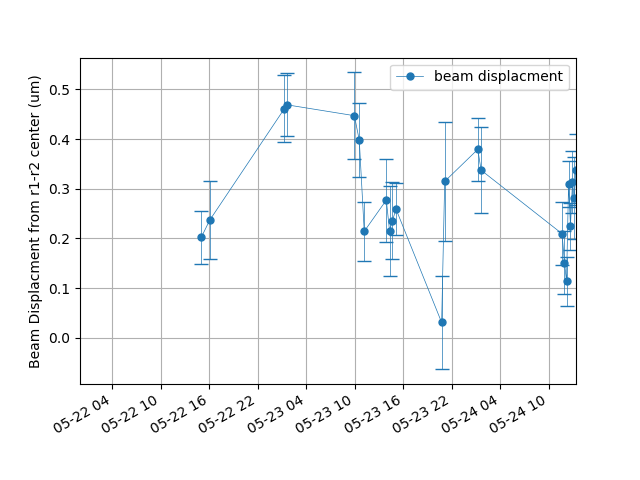

In [54]:
df4=pd.DataFrame({ "beam displacment": ratio_to_dist,'Max_error': dist_max_error,'Min_error': dist_min_error},index=startingtime)
ax=df4.plot(y=["beam displacment"],yerr=[dist_max_error,dist_min_error],capsize=5,lw=0.5,marker='o',markersize=5,color=['#1f77b4', '#d62728'])
ax.set_ylabel('Beam Displacment from r1-r2 center (um)')
ax.set_xlim(dt.datetime(2018,5,22))
ax.grid()

<IPython.core.display.Javascript object>


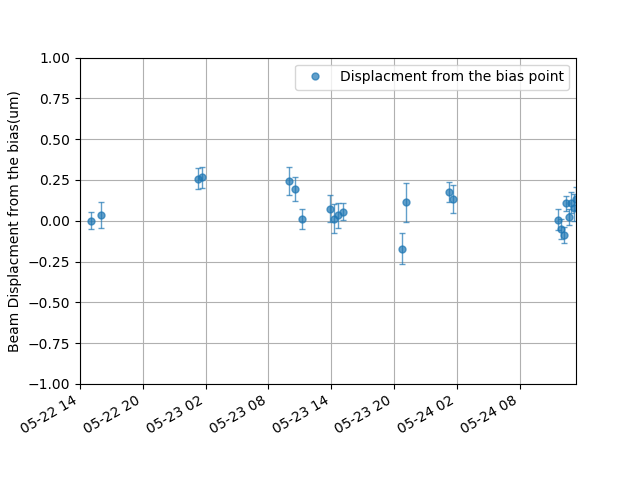

In [55]:
start_offset=np.mean(ratio_to_dist[0]) # Off
displacement_frombias=ratio_to_dist-start_offset
df5=pd.DataFrame({"Displacment from the bias point":displacement_frombias ,'Max_error': dist_max_error,'Min_error': dist_min_error},index=startingtime)
ax=df5.plot(y=["Displacment from the bias point"],yerr=[dist_max_error,dist_min_error],capsize=2,lw=1,marker='o',alpha=0.7,linestyle='None',markersize=5,color=['#1f77b4', '#d62728'])
ax.set_ylabel('Beam Displacment from the bias(um)')
ax.set_xlim(dt.datetime(2018,5,22,14))
ax.set_ylim(-1,1)
#days=md.DayLocator()
#ax.xaxis.set_major_locator(days)
#ax.xaxis.set_major_formatter(md.DateFormatter('%b %d'))

ax.grid()

<IPython.core.display.Javascript object>


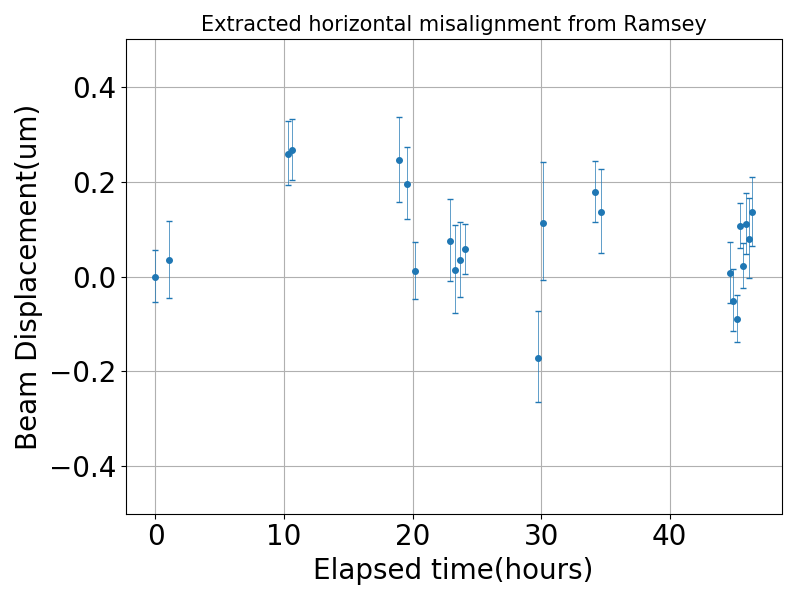

In [56]:
timediff=(startingtime_in_UNIX-startingtime_in_UNIX[0])/(3600)
fig, ax = plt.subplots()
fig.set_size_inches(8,6)
ax.errorbar(timediff,displacement_frombias,yerr=[dist_max_error,dist_min_error],capsize=2,alpha=1,lw=0.5,marker='o',markersize=4,linestyle='None')
ax.set_xlabel('Elapsed time(hours)',fontsize=20)
ax.set_ylabel('Beam Displacement(um)',fontsize=20)
ax.set_title('Extracted horizontal misalignment from Ramsey',fontsize=15)
ax.set_ylim(-0.5,0.5)
ax.tick_params(labelsize=20)
ax.grid()
plt.tight_layout()
filename='Extracted_horizontal_misalignment_from_Ramsey'
# plt.savefig(filename+'.png')
# plt.savefig(filename+'.pdf')
# plt.savefig(filename+'.eps')

# TIME SERIES ANALYSES

In [43]:
keylist=['Red_camera_dataX',
 'Red_camera_dataY',
  'FORT_camera_dataX',
'FORT_camera_dataY',
         'AAS_redside',
         'AAS_blueside',
 'timestamp_measurements',
 'timestamp_iteration']

actuator_variables=['Red_X','Red_Y']

# exp_ids : This is list for Ramsey experiments.
# There are more experients with AAS on. Add them in this list
AAS_ids=['2018_05_22_17_04_59_Closed loop without atoms',
         '2018_05_23_01_57_43_Closed loop without atoms',
         '2018_05_23_16_10_49_Closed loop with no atoms',
         '2018_05_23_18_43_54_Closed loop with no atoms',
         '2018_05_23_21_21_33_Closed loop with no atoms',
         '2018_05_23_22_59_47_Closed loop with no atoms',
        '2018_05_23_23_55_40_Closed loop with atoms',
         '2018_05_24_00_37_26_Closed loop with atoms',
        '2018_05_24_01_00_19_Closed loop with atoms',
         #'2018_05_24_01_10_08_Closed loop, scanning microwave freq',
         '2018_05_24_02_16_42_Closed loop with atoms, FORT lowered',
         '2018_05_24_02_29_20_Closed loop with no atoms' 
        ]

entire_closed_ids=exp_ids+AAS_ids


data={}
for j in range(0,len(entire_closed_ids)):
    exp_id=entire_closed_ids[j]
    q=open_data(exp_id)
    e=0
    for i in q.experiments[e]['iterations']:
        for key in keylist:
            if i==0 and j==0:
                data[key]=[]
            try:
                data[key].append(q.experiments[e]['iterations'][i][key])
            except:
                print "error occured : exp {}, iter {}, key {}".format(exp_id, i, key)

        for var in actuator_variables:
            if i==0 and j==0:
                data[var]=[]
            try:
                data[var].append(q.experiments[e]['iterations'][i]['variables'][var])
            except:
                print "error occured : exp {}, iter {}, key {}".format(exp_id, i, var)
                

Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_05_22/2018_05_22_15_00_26_Closed loop with Ramsey, r1-r2, changed aom freq/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_05_22/2018_05_22_16_02_17_Closed loop with Ramsey, r1-r2, changed aom freq/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_05_23/2018_05_23_01_17_11_Closed loop with atoms/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_05_23/2018_05_23_01_36_47_Closed loop with atoms/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_05_23/2018_05_23_09_57_07_Closed loop with atoms/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_05_23/2018_05_23_10_33_33_Closed loop with atoms/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :

In [12]:
dates

True

<IPython.core.display.Javascript object>


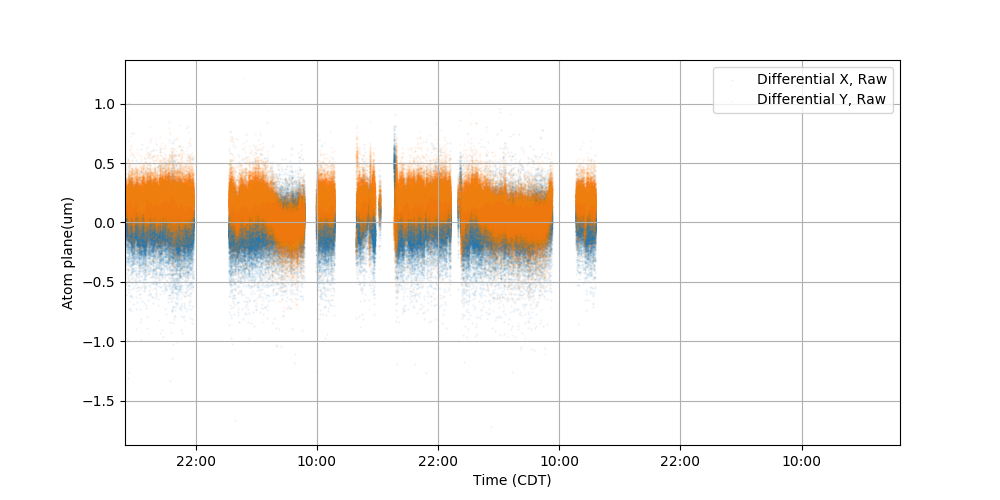

In [44]:
savefig=False
data_cutoff=0
xfmt=md.DateFormatter('%H:%M')
figW=10
figH=5
fig, ax = plt.subplots()
fig.set_size_inches(figW,figH)
flattendedtimestamps=np.array(flatten(data['timestamp_measurements']))
dates=[dt.datetime.fromtimestamp(ts) for ts in flattendedtimestamps][data_cutoff:]

flatteneddata0=np.array(flatten(data[keylist[0]]))[data_cutoff:]
flatteneddata2=np.array(flatten(data[keylist[2]]))[data_cutoff:]
flatteneddata1=np.array(flatten(data[keylist[1]]))[data_cutoff:]
flatteneddata3=np.array(flatten(data[keylist[3]]))[data_cutoff:]

ax.xaxis.set_major_formatter(xfmt)
data_to_plot=flatteneddata0-flatteneddata2-(flatteneddata0[0]-flatteneddata2[0])
ax.scatter(dates,data_to_plot,s=0.2,alpha=0.1,label='Differential X, Raw')
ax.set_xlim(dates[0],)
#ax.set_ylim(-1,1)

data_to_plot2=flatteneddata1-flatteneddata3-(flatteneddata1[0]-flatteneddata3[0])
ax.scatter(dates,data_to_plot2,s=0.2,alpha=0.1,label='Differential Y, Raw')
ax.grid()
ax.set_xlabel('Time (CDT)')
ax.set_ylabel('Atom plane(um)')
ax.legend()
if savefig:   
    plt.savefig('Alignment_over_night.png')

In [45]:
flattendedtimestamps[0]

1527019230.6429999

<IPython.core.display.Javascript object>


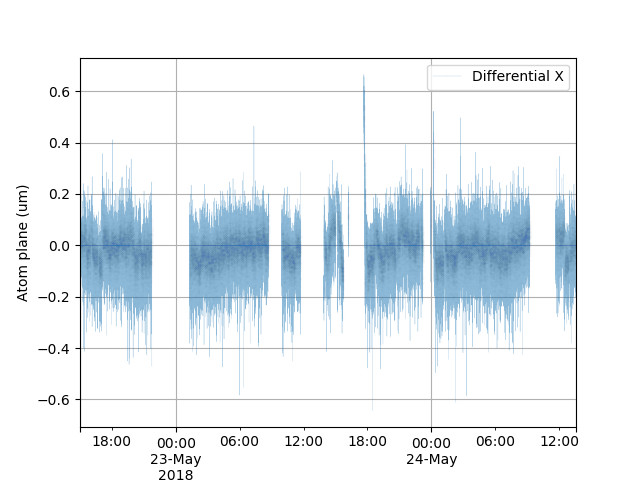

<IPython.core.display.Javascript object>


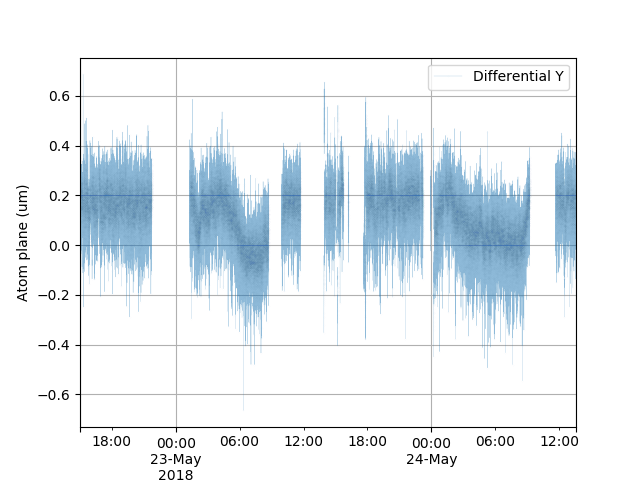

<IPython.core.display.Javascript object>


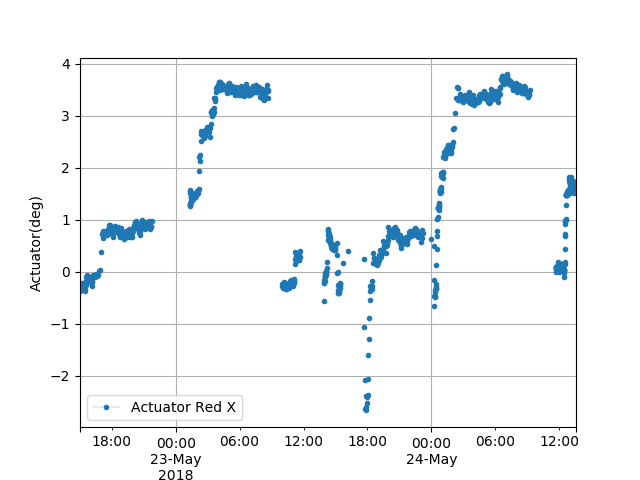

<IPython.core.display.Javascript object>


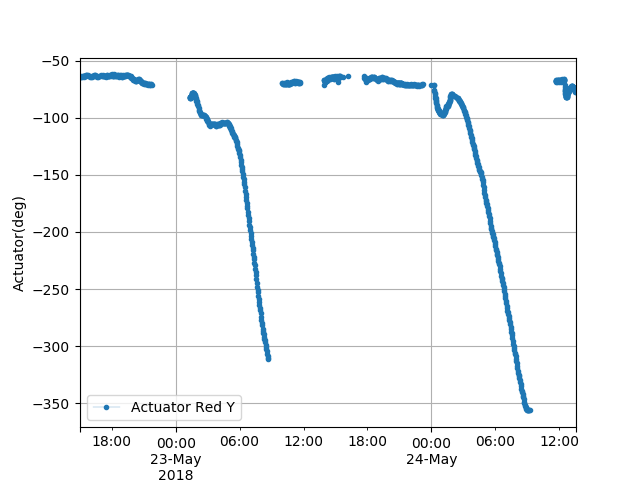

In [45]:
# Using Pandas
import pandas as pd
savefig=False
data_cutoff=0
flattendedtimestamps=np.array(flatten(data['timestamp_measurements']))

dates=[dt.datetime.fromtimestamp(ts) for ts in flattendedtimestamps][data_cutoff:]
dates_iterations=[dt.datetime.fromtimestamp(ts) for ts in data['timestamp_iteration']]

flatteneddata0=np.array(flatten(data[keylist[0]]))[data_cutoff:]
flatteneddata2=np.array(flatten(data[keylist[2]]))[data_cutoff:]
flatteneddata1=np.array(flatten(data[keylist[1]]))[data_cutoff:]
flatteneddata3=np.array(flatten(data[keylist[3]]))[data_cutoff:]

samplerate='1S'
offsetX=(flatteneddata0-flatteneddata2)[0]
offsetY=(flatteneddata1-flatteneddata3)[0]
df=pd.DataFrame({'Differential X': flatteneddata0-flatteneddata2-offsetX,
                 'Differential Y': flatteneddata1-flatteneddata3-offsetY,
                 'Red X': flatteneddata0,
                 'Red Y': flatteneddata1,
                 'FORT X': flatteneddata2,
                 'FORT Y': flatteneddata3,
                },index=dates)

df_actuators=pd.DataFrame({
                 'Actuator Red X':np.array(data['Red_X']),
                 'Actuator Red Y':np.array(data['Red_Y'])
                },index=dates_iterations)


## 
data_to_plot2=df.resample(samplerate).mean()
ax=data_to_plot2.plot(y=['Differential X'],alpha=0.5,lw=0.2,marker='.',markersize=0.02)
ax.set_ylabel('Atom plane (um)')
ax.grid()
ax.legend()

ax=data_to_plot2.plot(y=['Differential Y'],alpha=0.5,lw=0.2,marker='.',markersize=0.02)
ax.set_ylabel('Atom plane (um)')
ax.grid()
ax.legend()

data_to_plot3=df_actuators.resample(samplerate).mean()

ax=data_to_plot3.plot(y=['Actuator Red X'],alpha=1,lw=0.2,marker='.')
ax.set_ylabel('Actuator(deg)')
ax.grid()
ax.legend()

ax=data_to_plot3.plot(y=['Actuator Red Y'],alpha=1,lw=0.2,marker='.')
ax.set_ylabel('Actuator(deg)')
ax.grid()
ax.legend()

<IPython.core.display.Javascript object>


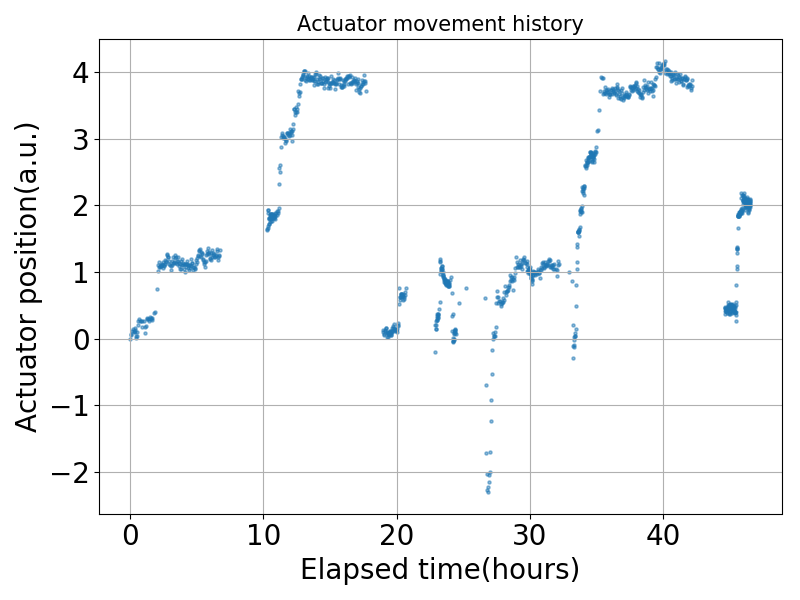

75
253
945
948


<IPython.core.display.Javascript object>


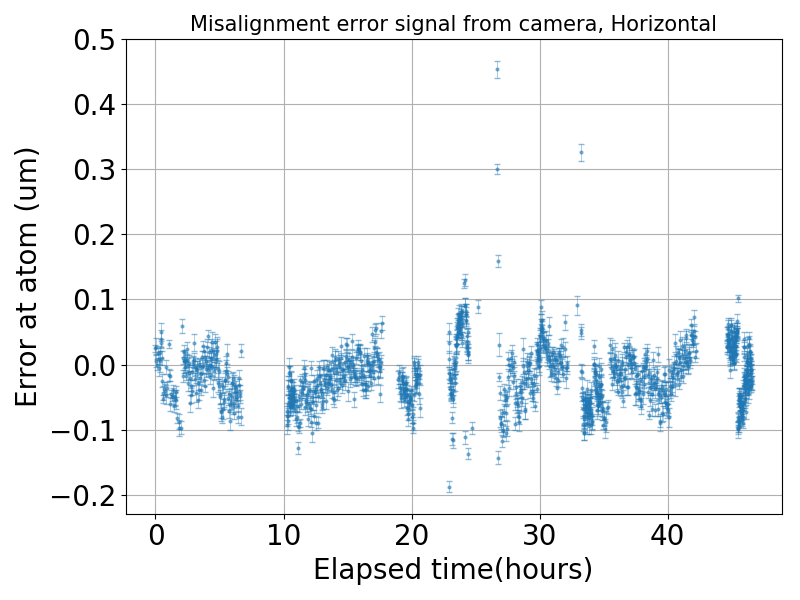

In [46]:
## Actuator Plot
savefig=True
actuator_x=np.array(data['Red_X'])
elapsed_time_in_hours=np.array(data['timestamp_iteration'])/3600.0-np.array(data['timestamp_iteration'][0])/3600.0

fig, ax = plt.subplots()
fig.set_size_inches(8,6)
plt.scatter(elapsed_time_in_hours,actuator_x-actuator_x[0],alpha=0.5,s=5)
ax.set_xlabel('Elapsed time(hours)',fontsize=20)
ax.set_ylabel('Actuator position(a.u.)',fontsize=20)
ax.set_title('Actuator movement history',fontsize=15)
ax.tick_params(labelsize=20)
ax.grid()
plt.tight_layout()
filename='Actuator X History'
if savefig:
    plt.savefig(filename+'.png')
    plt.savefig(filename+'.pdf')
    plt.savefig(filename+'.eps')

############ Camera error signal, X
camera_error_x=[]
camera_error_sigma_x=[]

samples=100
calibration_factor=12.0
elapsed_time_in_hours=np.array(data['timestamp_iteration'])/3600.0-np.array(data['timestamp_iteration'][0])/3600.0
for i in range(0,len(data[keylist[4]])):
    try:
        camera_error_x.append(data[keylist[4]][i]['error_x']/calibration_factor)
        camera_error_sigma_x.append(data[keylist[4]][i]['sigma_x']/math.sqrt(samples))
    except:
        print i
        camera_error_x.append(np.nan)
        camera_error_sigma_x.append(np.nan)
        
fig, ax = plt.subplots()
fig.set_size_inches(8,6)
ax.errorbar(elapsed_time_in_hours,camera_error_x,yerr=camera_error_sigma_x,capsize=2,alpha=0.5,lw=0.5,marker='o',markersize=2,linestyle='None')
ax.set_xlabel('Elapsed time(hours)',fontsize=20)
ax.set_ylabel('Error at atom (um)',fontsize=20)
ax.set_title('Misalignment error signal from camera, Horizontal',fontsize=15)
ax.tick_params(labelsize=20)
ax.grid()
plt.tight_layout()
filename='Camera AAS X History'
if savefig:
    plt.savefig(filename+'.png')
    plt.savefig(filename+'.pdf')
    plt.savefig(filename+'.eps')

<IPython.core.display.Javascript object>


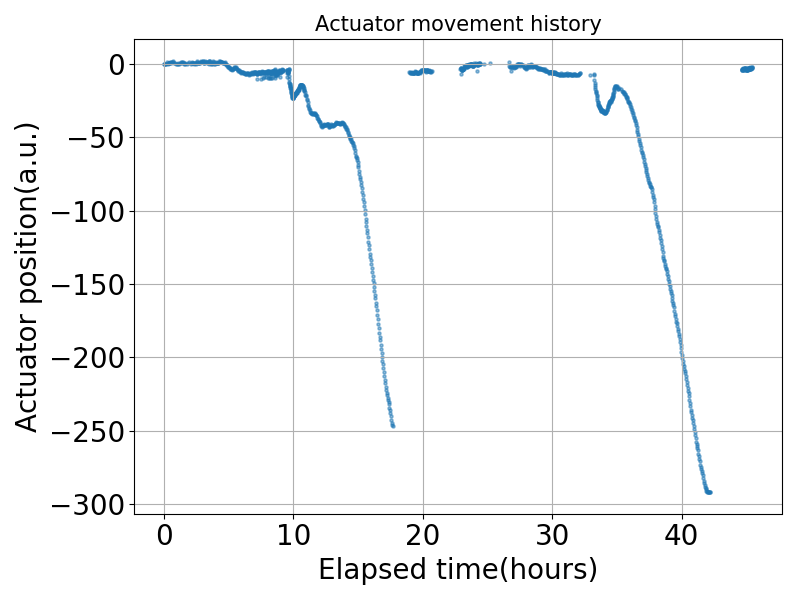

264
442
1029
1032


<IPython.core.display.Javascript object>


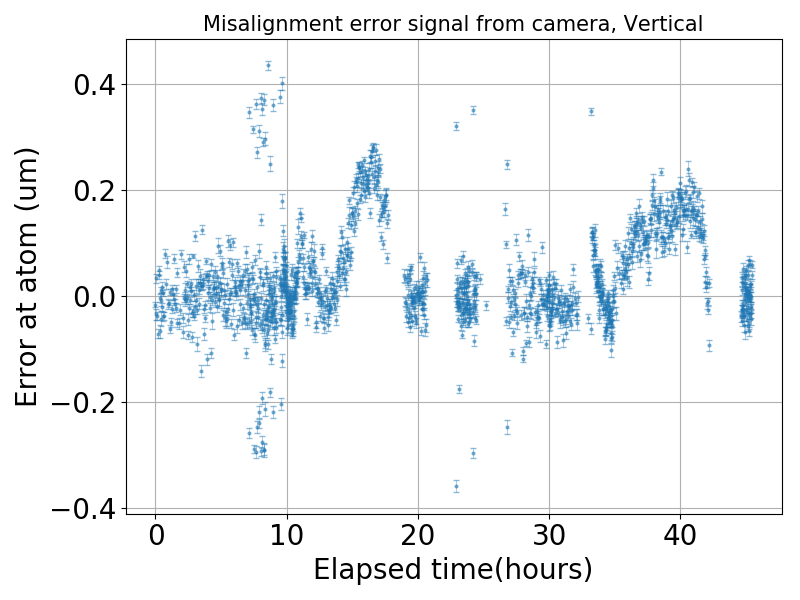

In [109]:
## Actuator Plot
savefig=True
actuator_y=np.array(data['Red_Y'])
elapsed_time_in_hours=np.array(data['timestamp_iteration'])/3600.0-np.array(data['timestamp_iteration'][0])/3600.0

fig, ax = plt.subplots()
fig.set_size_inches(8,6)
plt.scatter(elapsed_time_in_hours,actuator_y-actuator_y[0],alpha=0.5,s=5)
ax.set_xlabel('Elapsed time(hours)',fontsize=20)
ax.set_ylabel('Actuator position(a.u.)',fontsize=20)
ax.set_title('Actuator movement history',fontsize=15)
ax.tick_params(labelsize=20)
ax.grid()
plt.tight_layout()
filename='Actuator Y History'
if savefig:
    plt.savefig(filename+'.png')
    plt.savefig(filename+'.pdf')
    plt.savefig(filename+'.eps')

############ Camera error signal, Y
camera_error_y=[]
camera_error_sigma_y=[]

samples=100
calibration_factor=12.0
elapsed_time_in_hours=np.array(data['timestamp_iteration'])/3600.0-np.array(data['timestamp_iteration'][0])/3600.0
for i in range(0,len(data[keylist[4]])):
    try:
        camera_error_y.append(data[keylist[4]][i]['error_y']/calibration_factor)
        camera_error_sigma_y.append(data[keylist[4]][i]['sigma_y']/math.sqrt(samples))
    except:
        print i
        camera_error_y.append(np.nan)
        camera_error_sigma_y.append(np.nan)
        
fig, ax = plt.subplots()
fig.set_size_inches(8,6)
ax.errorbar(elapsed_time_in_hours,camera_error_y,yerr=camera_error_sigma_y,capsize=2,alpha=0.5,lw=0.5,marker='o',markersize=2,linestyle='None')
ax.set_xlabel('Elapsed time(hours)',fontsize=20)
ax.set_ylabel('Error at atom (um)',fontsize=20)
ax.set_title('Misalignment error signal from camera, Vertical',fontsize=15)
ax.tick_params(labelsize=20)
ax.grid()
plt.tight_layout()
filename='Camera AAS Y History'
if savefig:
    plt.savefig(filename+'.png')
    plt.savefig(filename+'.pdf')
    plt.savefig(filename+'.eps')

# Figuring out the dead region

<IPython.core.display.Javascript object>


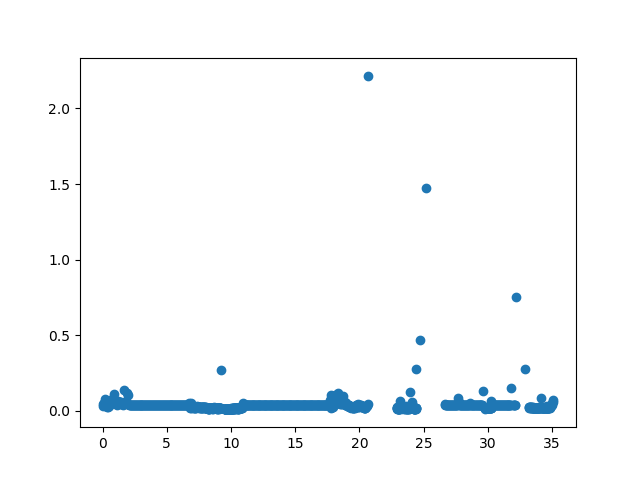

T=20.6829047222, duration of :2.21701666666


In [18]:
fig, ax= plt.subplots()
sorted_times=np.sort(elapsed_time_in_hours)
dead_times=sorted_times[1:]-sorted_times[0:-1]
ax.scatter(sorted_times[0:-1],dead_times)
threshold=2
dead_T=[]
dead_duration=[]
for i in range(0,len(dead_times)):
    if dead_times[i]>threshold:
        print 'T={}, duration of :{}'.format(sorted_times[0:-1][i],dead_times[i])
        dead_T.append(sorted_times[0:-1][i])
        dead_duration.append(dead_times[i])

<IPython.core.display.Javascript object>


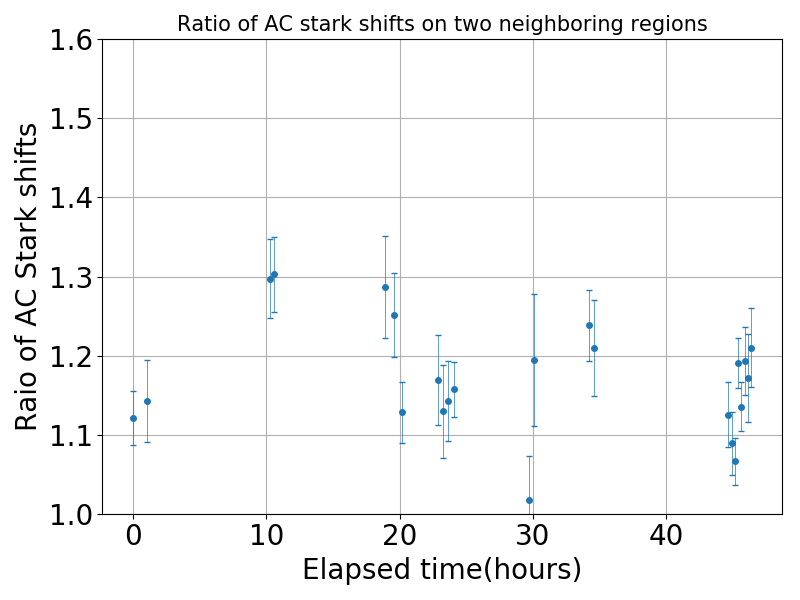

In [47]:
correction=0.7
fig, ax = plt.subplots()
fig.set_size_inches(8,6)
ax.errorbar(timediff,ratio_data,yerr=ratio_error,capsize=2,alpha=1,lw=0.5,marker='o',markersize=4,linestyle='None')
ax.set_xlabel('Elapsed time(hours)',fontsize=20)
ax.set_ylabel('Raio of AC Stark shifts',fontsize=20)
ax.set_title('Ratio of AC stark shifts on two neighboring regions',fontsize=15)
# for i in range(0,len(dead_T)):
#     ax.fill_between([dead_T[i]+correction,dead_T[i]+dead_duration[i]-correction],1.1-0.3,1.1+0.3,alpha=0.1,color='r')
ax.set_ylim(1.3-0.3,1.3+0.3)
ax.tick_params(labelsize=20)
ax.grid()
plt.tight_layout()

# Insert room temperature history

<IPython.core.display.Javascript object>


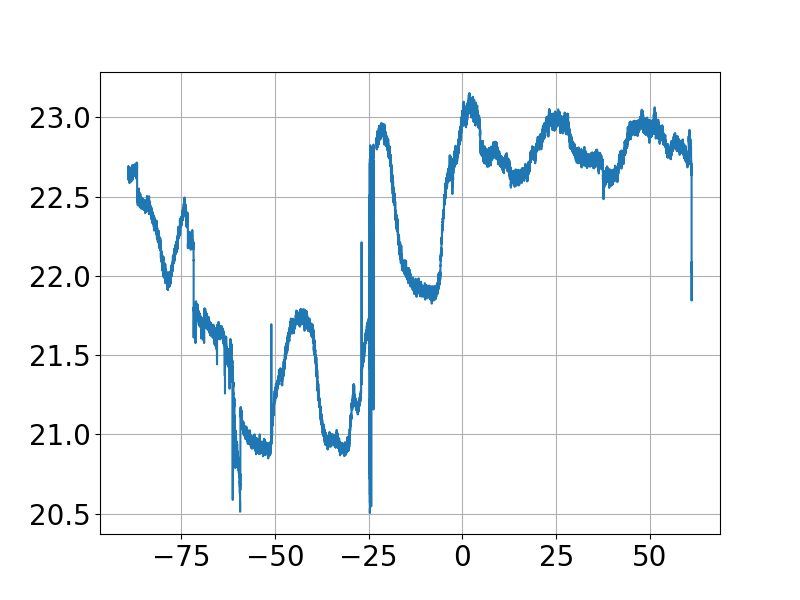

22.6327109524


In [48]:
from numpy import genfromtxt
my_data=genfromtxt('Rb_labtemperature.csv',delimiter=',')
temperatures_in_C=np.array(my_data[:,1])
timestamps=np.array(my_data[:,0])/2**32
offset=temperatures_in_C[0]#np.mean(temperatures_in_C)
experiment_start_time=flattendedtimestamps[0]
# Cutting weird data off (due to bad eletric connection.. etc)
temp_threshold_upper=25
temp_threshold_lower=20.5

indices1 = temperatures_in_C > temp_threshold_upper
indices2 = temperatures_in_C < temp_threshold_lower
final_indices=np.logical_or(indices1,indices2)
temperatures_in_C[final_indices]=np.NaN
fig, ax=plt.subplots()
fig.set_size_inches(8,6)
ax.plot((timestamps-experiment_start_time)/3600,temperatures_in_C)
ax.grid()
#ax.set_ylim(18,23)
ax.tick_params(labelsize=20)

# for i in range(0,len(dead_T)):
#      ax.fill_between([dead_T[i]+correction,dead_T[i]+dead_duration[i]-correction],-0.4,0.4,alpha=0.1,color='r')

print temperatures_in_C[0]

In [48]:
my_data

array([[  6.55712007e+18,   2.26327110e+01,   3.34742380e+03],
       [  6.55712008e+18,   2.26325596e+01,   3.34744660e+03],
       [  6.55712016e+18,   2.26359802e+01,   3.34693150e+03],
       ..., 
       [  6.55735520e+18,   2.24339886e+01,   3.37750250e+03],
       [  6.55735521e+18,   2.24349951e+01,   3.37734940e+03],
       [  6.55735522e+18,   2.24367175e+01,   3.37708740e+03]])

<IPython.core.display.Javascript object>


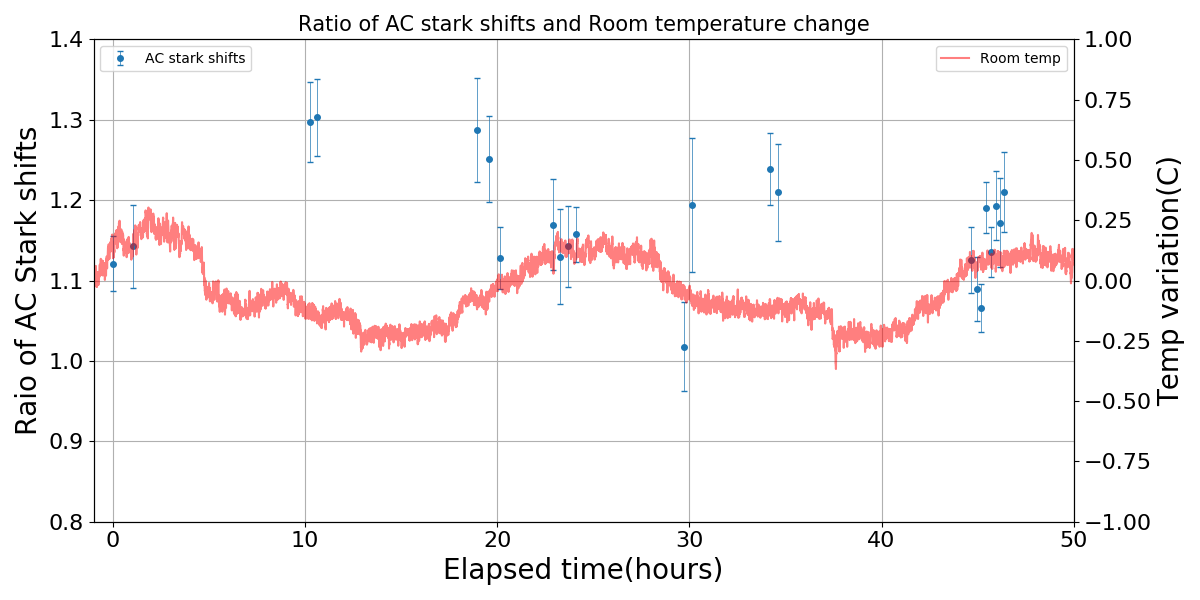

In [53]:
# Together!!
correction=0.7
fig, ax = plt.subplots()
fig.set_size_inches(12,6)
ax.errorbar(timediff,ratio_data,yerr=ratio_error,capsize=2,alpha=1,lw=0.5,marker='o',markersize=4,linestyle='None',label='AC stark shifts')
ax2=ax.twinx()
ax2.plot((timestamps-experiment_start_time)/3600,temperatures_in_C-offset,color='r',alpha=0.5,label='Room temp')
ax.set_xlabel('Elapsed time(hours)',fontsize=20)
ax.set_ylabel('Raio of AC Stark shifts',fontsize=20)
ax2.set_ylabel('Temp variation(C)',fontsize=20)
ax.set_title('Ratio of AC stark shifts and Room temperature change',fontsize=15)
# for i in range(0,len(dead_T)):
#     ax.fill_between([dead_T[i]+correction,dead_T[i]+dead_duration[i]-correction],1.1-0.3,1.1+0.3,alpha=0.1,color='gray')

ax.set_xlim(-1,50)
ax.set_ylim(1.1-0.3,1.1+0.3)
ax.tick_params(labelsize=16)
ax2.tick_params(labelsize=16)
ax2.set_ylim(-1,1)
ax.grid()
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
# filename='20180422_AC_starkshifts and temperature'
# plt.savefig(filename+'.png')
# plt.savefig(filename+'.pdf')
# plt.savefig(filename+'.eps')


<IPython.core.display.Javascript object>


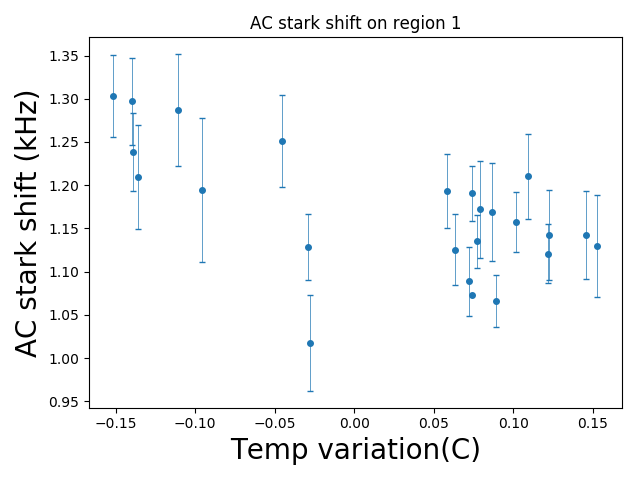

In [20]:
offset=22.85
interpolated_temperature=np.interp(timediff,(timestamps-experiment_start_time)/3600,temperatures_in_C-offset)
fig, ax=plt.subplots()
#ax.scatter(interpolated_temperature,ratio_data)
ax.errorbar(interpolated_temperature,ratio_data,yerr=ratio_error,capsize=2,alpha=1,lw=0.5,marker='o',markersize=4,linestyle='None')
#ax.set_aspect('equal')
ax.set_xlabel('Temp variation(C)',fontsize=20)
ax.set_ylabel('Raio of AC Stark shifts',fontsize=20)
ax.grid()

<IPython.core.display.Javascript object>


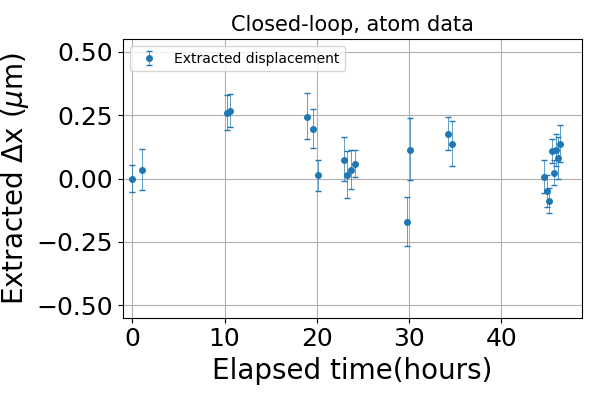

In [72]:
offset=22.85
display_ax2=False
timediff=(startingtime_in_UNIX-startingtime_in_UNIX[0])/(3600)
fig, ax = plt.subplots()
fig.set_size_inches(6,4)
ax.errorbar(timediff,displacement_frombias,yerr=[dist_max_error,dist_min_error],capsize=2,alpha=1,lw=0.5,marker='o',markersize=4,linestyle='None',label='Extracted displacement')
ax.set_xlabel('Elapsed time(hours)',fontsize=20)
ax.set_ylabel(r'Extracted $\Delta$x ($\mu$m)',fontsize=20)
ax.tick_params(labelsize=18)
scaler=1
ax.set_ylim(scaler*-0.55,scaler*0.55)

if display_ax2:
    ax2=ax.twinx()
    ax2.plot((timestamps-experiment_start_time)/3600,temperatures_in_C-offset,color='r',alpha=0.3,label='System temperature')
    ax2.set_ylim(scaler*-0.3,scaler*0.3)
    ax2.tick_params(labelsize=16)
    ax2.set_ylabel(r'Temp variation $\Delta$T (C)',fontsize=20)
    ax2.legend(loc='upper right')
ax.grid()
ax.legend(loc='upper left')
ax.set_title('Closed-loop, atom data',fontsize=15)
plt.tight_layout()
ax.set_xlim(-1,)
filename='20180522_Extracted_horizontal_misalignment_and_Temperature'
savefig=True
if savefig:
    plt.savefig(filename+'.png')
    plt.savefig(filename+'.pdf')
    plt.savefig(filename+'.eps')

<IPython.core.display.Javascript object>


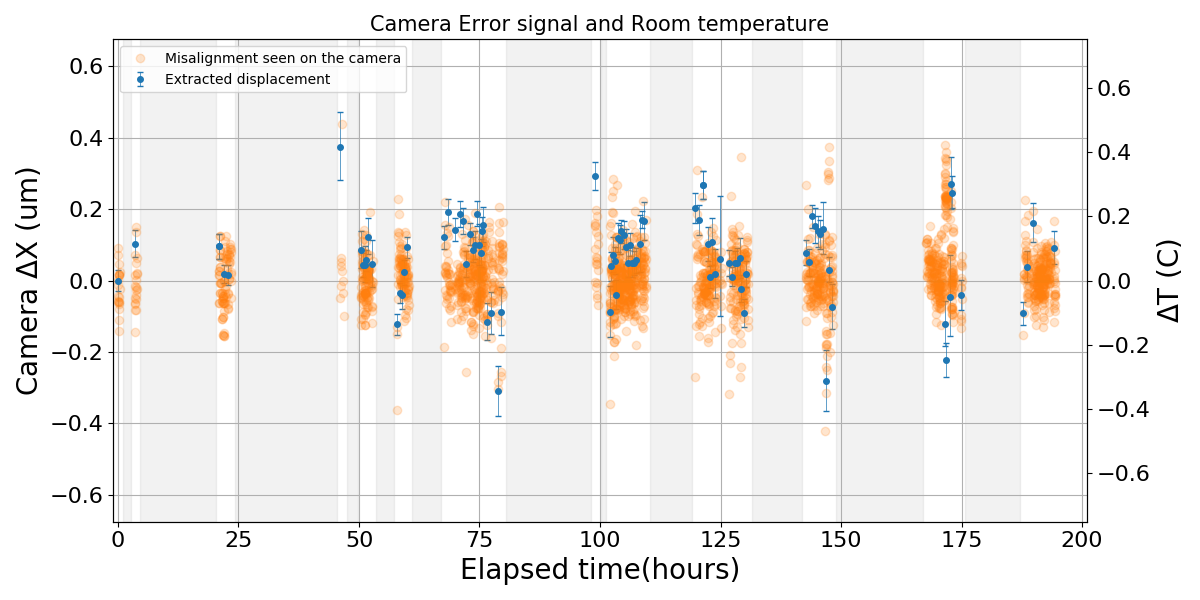

In [209]:
## Temperature and camera error signal plot
## Use pandas and resampling to plot them at similar time scale?
timediff=(startingtime_in_UNIX-startingtime_in_UNIX[0])/(3600)
fig, ax = plt.subplots()
fig.set_size_inches(12,6)
ax.errorbar(timediff,displacement_frombias,yerr=[dist_max_error,dist_min_error],capsize=2,alpha=1,lw=0.5,marker='o',markersize=4,linestyle='None',label='Extracted displacement')
ax.plot(elapsed_time_in_hours,camera_error_x,label='Misalignment seen on the camera',marker='o',linestyle='none',alpha=0.2)
ax2=ax.twinx()
#ax2.plot(timestamps,temperatures_in_C-offset,color='r',alpha=0.8,label='Room temp')
ax.set_xlabel('Elapsed time(hours)',fontsize=20)
ax.set_ylabel(r'Camera $\Delta$X (um)',fontsize=20)
ax2.set_ylabel(r'$\Delta$T (C)',fontsize=20)
ax.set_title('Camera Error signal and Room temperature',fontsize=15)
scaler=1.5
for i in range(0,len(dead_T)):
    ax.fill_between([dead_T[i]+correction,dead_T[i]+dead_duration[i]-correction],scaler*-0.45,scaler*0.45,alpha=0.1,color='gray')

ax.set_ylim(scaler*-0.45,scaler*0.45)
ax2.set_ylim(scaler*-0.5,scaler*0.5)
ax.tick_params(labelsize=16)
ax2.tick_params(labelsize=16)
ax.grid()
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
ax.set_xlim(-1,201)
filename='20180428_Camera_and_Atom_comparison'
savefig=True
if savefig:
    plt.savefig(filename+'.png')
    plt.savefig(filename+'.pdf')
    plt.savefig(filename+'.eps')

In [ ]:
## Temperature and camera error signal plot
## Use pandas and resampling to plot them at similar time scale?
timediff=(startingtime_in_UNIX-startingtime_in_UNIX[0])/(3600)
fig, ax = plt.subplots()
fig.set_size_inches(12,6)
#ax.errorbar(elapsed_time_in_hours,camera_error_x,yerr=camera_error_sigma_x,capsize=2,alpha=0.1,lw=0.5,marker='o',markersize=4,linestyle='None',label='Extracted displacement')
#ax.errorbar(elapsed_time_in_hours,camera_error_x,yerr=camera_error_sigma_x,capsize=2,alpha=0.5,lw=0.5,markersize=4,linestyle='None',label='Extracted displacement')
ax.plot(elapsed_time_in_hours,camera_error_x,label='Extracted displacement',marker='o',linestyle='none',alpha=0.2)
#ax.hexbin(elapsed_time_in_hours,camera_error_x,gridsize=(300,10),label='Extracted displacement')
#ax.hexbin(elapsed_time_in_hours,camera_error_x,gridsize=(300,10),label='Extracted displacement')
ax2=ax.twinx()
ax2.plot(timestamps,temperatures_in_C-offset,color='r',alpha=0.8,label='Room temp')
ax.set_xlabel('Elapsed time(hours)',fontsize=20)
ax.set_ylabel(r'Camera $\Delta$X (um)',fontsize=20)
ax2.set_ylabel(r'$\Delta$T (C)',fontsize=20)
ax.set_title('Camera Error signal and Room temperature',fontsize=15)
scaler=1.5
for i in range(0,len(dead_T)):
    ax.fill_between([dead_T[i]+correction,dead_T[i]+dead_duration[i]-correction],scaler*-0.45,scaler*0.45,alpha=0.1,color='gray')

ax.set_ylim(scaler*-0.45,scaler*0.45)
ax2.set_ylim(scaler*-0.5,scaler*0.5)
ax.tick_params(labelsize=16)
ax2.tick_params(labelsize=16)
ax.grid()
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
ax.set_xlim(-1,201)
filename='20180428_camera_horizontal_misalignment_and_Temperature'
savefig=False
if savefig:
    plt.savefig(filename+'.png')
    plt.savefig(filename+'.pdf')
    plt.savefig(filename+'.eps')

<IPython.core.display.Javascript object>


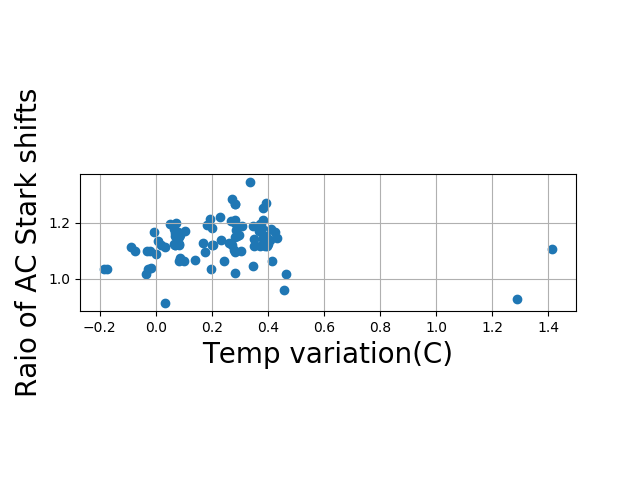

In [51]:
interpolated_temperature=np.interp(timediff,timestamps,temperatures_in_C-offset)
fig, ax=plt.subplots()
ax.scatter(interpolated_temperature,ratio_data)
ax.set_aspect('equal')
ax.set_xlabel('Temp variation(C)',fontsize=20)
ax.set_ylabel('Raio of AC Stark shifts',fontsize=20)
ax.grid()

<IPython.core.display.Javascript object>


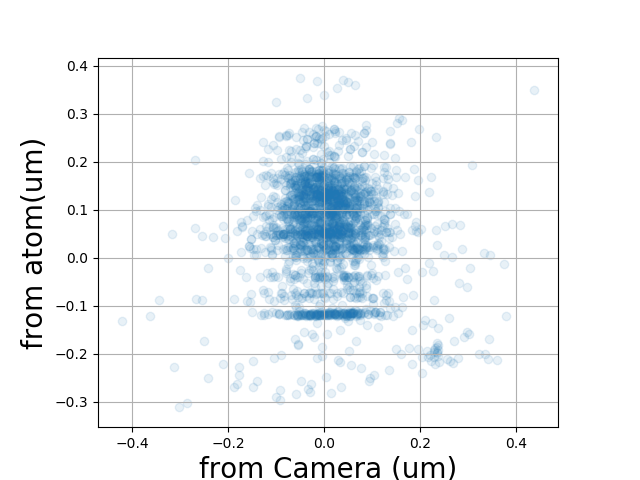

In [172]:
# Camera Error signal vs Atom signal
# elapsed_time_in_hours,camera_error_x,yerr=camera_error_sigma_x
time_offset=0
#interpolated_error_x=np.interp(timediff+time_offset,elapsed_time_in_hours,camera_error_x)
interpolated_atom_x=np.interp(elapsed_time_in_hours+time_offset,timediff,displacement_frombias)
fig, ax=plt.subplots()
#ax.hexbin(camera_error_x,interpolated_atom_x,gridsize=40)
#ax.scatter(camera_error_x,interpolated_atom_x,alpha=0.1)
ax.set_aspect('equal')
ax.set_xlabel('from Camera (um)',fontsize=20)
ax.set_ylabel('from atom(um)',fontsize=20)
ax.grid()
ax.set_aspect('equal')

In [154]:
np.size(elapsed_time_in_hours)

2195

In [126]:
timediff

array([   0.        ,    3.48471694,   20.94659722,   20.94659722,
         22.02374889,   22.83502472,   46.14175194,   50.43195417,
         50.84260028,   51.18150556,   51.51876861,   51.89722056,
         52.62958306,   57.91884361,   58.47059389,   58.96669083,
         59.43727583,   59.87217111,   67.66185556,   68.4693075 ,
         69.94930583,   70.91257583,   71.56578667,   72.24758389,
         72.94265833,   73.585415  ,   73.98553194,   74.47450361,
         74.86974083,   75.21645028,   75.52191667,   75.8017675 ,
         76.52271417,   77.30667389,   78.7948975 ,   79.47338528,
         98.91573222,  102.01844167,  102.33729306,  102.68075111,
        103.04679111,  103.39736528,  103.73350472,  104.14270861,
        104.44181667,  104.89870722,  105.32815   ,  105.78663028,
        106.17394333,  106.56550694,  106.95965389,  107.38826667,
        108.2555825 ,  108.67492139,  109.06880278,  119.80086333,
        120.55649056,  121.37411861,  121.37411861,  122.35684

# Allan deviation

In [144]:
from IPython.display import display, clear_output
# Allan 
tau_list=range(1,100)+range(101,1001,10)+range(1002,10002,10)+range(10003,100003,10)#+range(80004,100004,50)+range(100005,1000005,500)
samplerates=[]
for i in tau_list:
    samplerates.append('{}S'.format(i))
        
samplerate='1S'

var_list={}

original_resampled=df.resample(samplerate).mean()

for i in range(0,len(tau_list)):
    avg_samplerate=samplerates[i]
    tau=tau_list[i]
    clear_output()
    display('Tau: '+str(tau))
    try:
        downsampled=df.resample(avg_samplerate).mean() # Takes block-average for given time chuck size
        for key in downsampled:
            values=downsampled[key].values
            Xtau=values[1:]
            Xo=values[0:-1]
            var=np.nanmean(np.abs(Xtau-Xo))
            if i==0:
                var_list[key]=[]
            var_list[key].append(var)
    except:
        pass
    
try:
    np.save('20180525_closedloop_taulist',tau_list)
    np.save('20180525_closedloop_X',np.sqrt(0.5*np.array(var_list['Differential X'])))
    np.save('20180525_closedloop_Y',np.sqrt(0.5*np.array(var_list['Differential Y'])))
except:
    pass

'Tau: 99993'

<IPython.core.display.Javascript object>


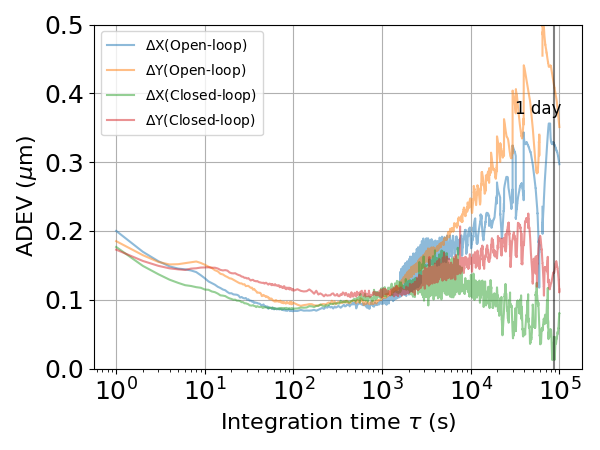

In [175]:
tau_list=np.load('20180525_openloop_taulist.npy')
Xlist=np.load('20180525_openloop_X.npy')
Ylist=np.load('20180525_openloop_Y.npy')

tau_list2=np.load('20180525_closedloop_taulist.npy')
Xlist2=np.load('20180525_closedloop_X.npy')
Ylist2=np.load('20180525_closedloop_Y.npy')


savefig=True
fig, ax = plt.subplots()
fig.set_size_inches(6,4.5)
ax.semilogx(tau_list, Xlist,label=r'$\Delta$X(Open-loop)',alpha=0.5)
ax.semilogx(tau_list, Ylist,label=r'$\Delta$Y(Open-loop)',alpha=0.5)
ax.semilogx(tau_list2, Xlist2,label=r'$\Delta$X(Closed-loop)',alpha=0.5)
ax.semilogx(tau_list2, Ylist2,label=r'$\Delta$Y(Closed-loop)',alpha=0.5)
ax.tick_params(labelsize=18)
ax.legend()
plt.axvline(x=86400,color='black',alpha=0.5)
#ax.set_xlim(1,)
#ax.set_title('Allan Deviation (Open-loop vs Closed-loop)',size=)
ax.set_xlabel(r'Integration time $\tau$ (s)',size=16)
ax.set_ylabel(r'ADEV ($\mu$m)',size=16)
#ax.text(10**0,0.3,'Feedback uses last 100 measurements(~ 30 sec)\n from each iteration.\nFeedback cycle time typically ~ 2 min, when activated')
ax.text(10**4.5,0.37,'1 day',size=12)
#ax.axvline(x=60,color='k',alpha=0.3)
ax.set_ylim(0.0,0.5)
ax.grid()
plt.tight_layout()
filename='20180522_AllanDeviation_comparison'
if savefig:
    plt.savefig(filename+'.png')
    plt.savefig(filename+'.pdf')
    plt.savefig(filename+'.eps')
